# GIS AMOC interaction: real data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

from tigramite import data_processing as pp
from tigramite import plotting as tp

import pandas as pd
import xarray as xr

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import cartopy.crs as ccrs

import re
import pickle

from tigramite.causal_effects import CausalEffects
from tigramite.data_processing import DataFrame

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from statsmodels.tsa.stattools import pacf

from tigramite.pcmci import PCMCI
from tigramite.plotting import plot_time_series_graph as plot_graph

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.cmiknn import CMIknn

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
%cd /Users/alexandrine/Library/CloudStorage/OneDrive-TechnischeUniversitätBerlin/causal_detection_of_CSD/
import functions.shift_detection as shiftdetect
import functions.sliding_windows as sw
import functions.indicators_computation as ind
import functions.significance_testing as sgtest
import functions.helpers as helpers

/Users/alexandrine/Library/CloudStorage/OneDrive-TechnischeUniversitätBerlin/causal_detection_of_CSD


# helpers

In [3]:
def compute_weighted_slope(x, y, weights):
    # Create a diagonal matrix W from the weights
    W = np.diag(weights)
    
    # Create the design matrix X by stacking x and a column of ones (for the intercept)
    X = np.vstack([x, np.ones(len(x))]).T
    
    # Compute the weighted least squares solution
    beta = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)     # beta = (X^T * W * X)^(-1) * (X^T * W * y)
    
    slope = beta[0]
    intercept = beta[1]
    
    residuals = y - (slope * x + intercept)
    mean_residual = np.mean(np.abs(residuals))
    std_dev_y = np.std(y)
    
    return slope, mean_residual, std_dev_y, intercept

def compute_effect_slopes_weighted(causal_autodependencies, densities, nb_edge_points, intervention_data_windows):
    effect_slopes = []
    residuals = []
    std_devs = []
    intercepts = []

    for i in range(len(causal_autodependencies)):
        x = intervention_data_windows[i]
        y = causal_autodependencies[i]
        density = densities[i](x)
        weights = density / np.sum(density)  # Normalize densities to use as weights
        weights[:nb_edge_points], weights[-nb_edge_points:] = [0]*nb_edge_points, [0]*nb_edge_points

        try:
            slope, residual, std_dev, intercept = compute_weighted_slope(x, y, weights)
            effect_slopes.append(slope)
            residuals.append(residual)
            std_devs.append(std_dev)
            intercepts.append(intercept)
        except np.linalg.LinAlgError:
            raise ValueError(f"Error in weighted least squares for time window number: {i}")

    return effect_slopes, residuals, std_devs, intercepts


In [4]:
def plot_window_length_analysis(causal_effects, data, var_names, time_windows, rows, cols, n_points, estimator, data_transform, edge_points_proportion=0.1):
    densities = ind.windows_density(data, time_windows)
    causal_autodependencies, intervention_data_windows = ind.non_linear_causal_autodependency(
        causal_effects, data, var_names, 
        time_windows=time_windows, n_points=n_points, 
        estimator=estimator, data_transform=data_transform
    )

    largest_slopes = []
    nb_edge_points = int(edge_points_proportion * n_points)

    # Calculate slopes for each window to include in subplot titles
    subplot_titles = []
    for i in range(len(causal_autodependencies)):
        x = intervention_data_windows[i]
        y = causal_autodependencies[i]
        density = densities[i](x)

        mask = np.arange(n_points)
        center_mask = (mask >= nb_edge_points) & (mask < (n_points - nb_edge_points))
        weights = np.copy(density)
        weights /= np.sum(weights)
        weights[~center_mask] = 0

        try:
            slope, residual, std_dev, intercept = compute_weighted_slope(x, y, weights)
            largest_slopes.append(slope)
            subplot_titles.append(f'W{i}, slope={slope:.2f}')
        except np.linalg.LinAlgError:
            print(f"LinAlgError in window {i}, skipping.")
            subplot_titles.append(f'Window {i}, slope=N/A')

    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=subplot_titles, 
        shared_xaxes=False,
        specs=[[{"secondary_y": True} for _ in range(cols)] for _ in range(rows)]
    )

    for i in range(len(causal_autodependencies)):
        row = i // cols + 1
        col = i % cols + 1

        x = intervention_data_windows[i]
        y = causal_autodependencies[i]
        density = densities[i](x)

        mask = np.arange(n_points)
        center_mask = (mask >= nb_edge_points) & (mask < (n_points - nb_edge_points))
        weights = np.copy(density)
        weights /= np.sum(weights)
        weights[~center_mask] = 0

        try:
            slope, residual, std_dev, intercept = compute_weighted_slope(x, y, weights)

            # causal effects points
            fig.add_trace(go.Scatter(x=x, y=y, mode='markers', marker=dict(size=6), line=dict(color='#87CDDE'), name="Estimated CE", showlegend=(i==0)), row=row, col=col)

            # slope
            x_center = x[center_mask]
            y_fit = slope * x_center + intercept
            fig.add_trace(go.Scatter(x=x_center, y=y_fit, mode='lines', line=dict(color='#37ABC8'), name=f'Slope: {slope:.2f}', showlegend=(i==0)), row=row, col=col)

            # Density
            fig.add_trace(go.Scatter(x=x, y=density, mode='lines', line=dict(color='#FF9955'), name="p(Y)", showlegend=(i==0)), row=row, col=col, secondary_y=True)
        except np.linalg.LinAlgError:
            print(f"LinAlgError in window {i}, skipping.")

        fig.update_xaxes(title_text="Intervention data", row=row, col=col, showgrid=False)
        fig.update_yaxes(title_text="Causal effect", row=row, col=col, showgrid=False)
        fig.update_yaxes(title_text="p(Y)", row=row, col=col, secondary_y=True)

    fig.update_layout(
        height=300 * rows, width=450 * cols, 
        plot_bgcolor='rgba(215, 238, 244, 0.3)',
        showlegend=True, legend_title="Legend",
    )

    fig.show()

    return largest_slopes, fig

In [5]:
def bootstrap_causal_autodependency(causal_effects, data, var_names, time_windows, n_points, estimator, n_bootstrap, boot_blocklength, data_transform=None, detrend=False, seed=0):
    estimated_causal_effects = []
    intervention_data_windows = []
    data_copy=data.copy()
    data_length = data_copy.shape[0]

    # Initialize the bootstrap preds list: one list per bootstrap sample
    bootstrap_preds_by_sample = [[] for _ in range(n_bootstrap)]

    for window in time_windows:
        if window[-1] >= data_length:
            break  # Stop if the entire window is not included in the data

        # work on a temporary local copy for this window
        window_slice = data_copy[window, :].copy()
        if detrend:
            wlen = window_slice.shape[0]
            t = np.arange(wlen)
            for i in range(window_slice.shape[1]):
                xw_i = window_slice[:, i].astype(float).copy()
                xw_i = xw_i - xw_i.mean()
                slope, intercept = np.polyfit(t, xw_i, 1)
                detrended = xw_i - (slope * t + intercept)
                window_slice[:, i] = detrended


        dataframe = pp.DataFrame(window_slice, var_names=var_names)
        intervention_data_window, intervention_data_window_here = ind.produce_intervention_data(window_slice[:, -1], 0.01, n_points)
        
        # Fit causal effect model from observational data
        causal_effects.fit_total_effect(
                dataframe = dataframe, 
                estimator=estimator,
                adjustment_set='optimal',
                conditional_estimator=None,  
                data_transform=data_transform,
                mask_type=None,
            )
        
        causal_effects.fit_bootstrap_of(
            method='fit_total_effect',
            method_args={'dataframe':dataframe, 'estimator':estimator, 'adjustment_set':'optimal', 'conditional_estimator':None, 'data_transform':data_transform, 'mask_type':None,},
            boot_samples=n_bootstrap,
            boot_blocklength=boot_blocklength,
            seed=seed,
        )

        # Predict causal effect for the current window
        # and bootstrap samples
        if data_transform is not None:
            window_estimated_causal_effects = causal_effects.predict_total_effect( 
                intervention_data=intervention_data_window_here,
                transform_interventions_and_prediction=True,)
            
            preds, _ = causal_effects.predict_bootstrap_of(
                method='predict_total_effect',
                method_args={'intervention_data':intervention_data_window_here, 'transform_interventions_and_prediction':True,},
                return_individual_bootstrap_results=True
            )
    
        else:
            window_estimated_causal_effects = causal_effects.predict_total_effect( 
                intervention_data=intervention_data_window_here,
                transform_interventions_and_prediction=False,)
            
            preds, _ = causal_effects.predict_bootstrap_of(
                method='predict_total_effect',
                method_args={'intervention_data':intervention_data_window_here, 'transform_interventions_and_prediction':False,},
                return_individual_bootstrap_results=True
            )  
        # Append each window's predictions to the correct bootstrap sample
        for i in range(n_bootstrap):
            bootstrap_preds_by_sample[i].append(preds[i, :].tolist())      

        estimated_causal_effects.append(window_estimated_causal_effects)
        intervention_data_windows.append(intervention_data_window)


    return estimated_causal_effects, bootstrap_preds_by_sample, intervention_data_windows

In [6]:
def pipeline_causalEE_weighted_bootstrap(causal_effects, data, estimator, n_bootstrap, boot_blocklength, data_transform, n_points, time_windows, var_names, edge_points_proportion=0.05, CI=90, detrend=False, seed=0):
    bootstrap_estimates = []

    causal_autodependencies, bootstrap_causal_estimates, intervention_data_windows = bootstrap_causal_autodependency(
        causal_effects, data, var_names=var_names, 
        time_windows=time_windows, n_points=n_points, 
        estimator=estimator, n_bootstrap=n_bootstrap, 
        boot_blocklength=boot_blocklength, data_transform=data_transform,
        detrend=detrend,
        seed=seed
    )

    densities = ind.windows_density(data, time_windows=time_windows)

    nb_edge_points=int(edge_points_proportion*n_points)
    effect_slopes, residuals, std_devs = ind.compute_effect_slopes_weighted(causal_autodependencies, densities, nb_edge_points, intervention_data_windows)

    for estimate in bootstrap_causal_estimates: # estimate = causal effects for one bootstrap sample
        slope, _, _ = ind.compute_effect_slopes_weighted(estimate, densities, nb_edge_points, intervention_data_windows)
        bootstrap_estimates.append(slope)

    if CI==90:
        confidence_interval = np.percentile(bootstrap_estimates, [5, 95], axis=0)
    elif CI==95:
        confidence_interval = np.percentile(bootstrap_estimates, [2.5, 97.5], axis=0)

    return effect_slopes, residuals, std_devs, bootstrap_estimates, confidence_interval

In [7]:
def boxplot_results_for_each_graph(graphs, nb_surrogates):
    """
    graphs: list of dicts, each dict must have:
      - 'label': str, name for x-axis and legend
      - 'values': array-like (time series for central slope)
      - 'bootstrap_values': list of arrays (bootstrap time series)
      - optional 'color': string (plot color)
    nb_surrogates: int, number of surrogates for p-value computation
    """

    def compute_slopes_and_pvalues(bootstrap_series_list):
        slopes, pvals = [], []
        for series in bootstrap_series_list:
            slope, _ = np.polyfit(np.arange(len(series)), series, 1)
            pval, _ = sgtest.p_value_from_fourier(series, nb_surrogates, slope)
            pvals.append(float(np.array(pval).flatten()[0]))
            slopes.append(slope)
        return slopes, pvals

    def extract_pval(value):
        slope, _ = np.polyfit(np.arange(len(value)), value, 1)
        pval, _ = sgtest.p_value_from_fourier(value, nb_surrogates, slope)
        return slope, float(np.array(pval).flatten()[0])

    fig = go.Figure()

    default_colors = ['rgb(0,153,198)', 'rgb(115,175,72)', 'rgb(255,127,14)', 'rgb(31,119,180)', 'rgb(44,160,44)']
    n_colors = len(default_colors)

    central_vals = []
    central_pvals = []
    x_labels = []
    all_bootstrap_slopes = []
    all_bootstrap_pvals = []
    colors = []

    # Compute slopes and pvals for each graph dynamically
    for i, graph in enumerate(graphs):
        label = graph['label']
        values = graph['values']
        bootstrap_values = graph['bootstrap_values']
        color = graph.get('color', default_colors[i % n_colors])

        slopes, pvals = compute_slopes_and_pvalues(bootstrap_values)
        slope, pval = extract_pval(values)

        central_vals.append(slope)
        central_pvals.append(pval)
        x_labels.append(label)
        all_bootstrap_slopes.append(slopes)
        all_bootstrap_pvals.append(pvals)
        colors.append(color)

    # Add boxplots (background)
    for i, slopes in enumerate(all_bootstrap_slopes):
        fig.add_trace(go.Box(
            y=slopes,
            x=[i] * len(slopes),
            name='',
            marker_color=colors[i],
            boxpoints=False,
            line_width=1,
            fillcolor=colors[i].replace('rgb', 'rgba').replace(')', ',0.1)'),
            showlegend=False
        ))

    # Add bootstrap points (colored, no legend)
    for i, (slopes, pvals, color) in enumerate(zip(all_bootstrap_slopes, all_bootstrap_pvals, colors)):
        for slope, pval in zip(slopes, pvals):
            symbol = 'circle' if pval < 0.01 else 'x'
            fig.add_trace(go.Scatter(
                x=[i],
                y=[slope],
                mode='markers',
                marker=dict(
                    symbol=symbol,
                    size=8,
                    color=color,
                    opacity=0.7
                ),
                hoverinfo='skip',
                showlegend=False,
            ))

    # Add central points (larger, black outline)
    for i, (val, pval, color) in enumerate(zip(central_vals, central_pvals, colors)):
        symbol = 'circle' if pval < 0.01 else 'x'
        fig.add_trace(go.Scatter(
            x=[i],
            y=[val],
            mode='markers+text',
            marker=dict(
                symbol=symbol,
                size=12,
                color=color,
                line=dict(width=2, color='black')
            ),
            #text=[x_labels[i]],
            #textposition='top center',
            showlegend=False
        ))

    # Add legend markers (black only, once)
    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode='markers',
        marker=dict(symbol='circle', size=9, color='black'),
        name='p < 0.01'
    ))
    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode='markers',
        marker=dict(symbol='x', size=9, color='black'),
        name='p ≥ 0.01'
    ))

    fig.update_layout(
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(len(x_labels))),
            ticktext=x_labels
        ),
        yaxis_title="Slope",
        height=600,
        width=750 + 60 * (len(graphs) - 3),  # widen plot if many graphs
        template='simple_white',
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='center',
            x=0.5
        )
    )

    fig.show()

# Import data

### JJA, CWG, NU
JJA air temperature, CWG and Nu melt rates are from: Nonlinear rise in Greenland runoff in response to post-industrial Arctic warming, Trusel et al., Nature, 2018

They are used by Boers and Rypdal in: Critical slowing down suggests that the western Greenland Ice Sheet is close to a tipping point, Boers&Rypdal, PNAS, 2021

with window size=70 years

### FWF
FWF are from: Land Ice Freshwater Budget of the Arctic and North Atlantic Oceans: 1. Data, Methods, and Results, Bamber et al., AGU Publications, 2018


### AMOC proxies

Caesar: $I_{AMOC} = SST_{sg} - SST_{global}$

Ditlevsen: $I_{AMOC} = SST_{sg\_ anomaly} - 2 * SST_{global\_ anomaly}$
\
anomalies: records subtracted the monthly mean over the full record (from preindustrial to 2020)

### Melt rates and AMOC Caesar

In [8]:
# GIS, Arctic summer temperature, AMOC
file_path = "data/JJA_CWG_NU.xlsx"
JJA_CWG_NU_AMOC = pd.read_excel(file_path)
JJA_CWG_NU_AMOC = JJA_CWG_NU_AMOC[["Year", "JJA", "CWG", "NU", "AMOC_Caesar"]]

In [9]:
JJA_CWG_NU_AMOC

Year       JJA        CWG        NU  AMOC_Caesar
0    2013  6.533333   0.034009  2.164248    -8.759240
1    2012  8.033333  11.038916  1.087561    -8.863189
2    2011  7.500000   1.992249  3.452864    -8.610168
3    2010  8.100000   1.739967  2.436886    -8.898290
4    2009  7.566667   1.838914  1.835124    -8.817147
..    ...       ...        ...       ...          ...
359  1654       NaN        NaN  0.145832          NaN
360  1653       NaN        NaN  0.793482          NaN
361  1652       NaN        NaN -0.847182          NaN
362  1651       NaN        NaN -1.088726          NaN
363  1650       NaN        NaN -0.589847          NaN

[364 rows x 5 columns]

In [10]:
df_1871_2013 = JJA_CWG_NU_AMOC[JJA_CWG_NU_AMOC['Year'] >= 1871]
df_1871_2013 = df_1871_2013.iloc[::-1].reset_index(drop=True)
years_1871_2013 = list(df_1871_2013["Year"])
df_1871_2013 = df_1871_2013.set_index('Year')

#df_1871_2013

### Temperature

https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/download.html

In [11]:
from netCDF4 import Dataset
temp = Dataset('data/HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc')

In [12]:
temp

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    comment: 2m air temperature over land blended with sea water temperature at a depth of 20cm expressed as monthly anomalies relative to 1961-1990 climatology.
    history: Data set built at: 2025-04-30T17:33:58+00:00
    institution: Met Office Hadley Centre / Climatic Research Unit, University of East Anglia
    licence: HadCRUT5 is licensed under the Open Government Licence v3.0 except where otherwise stated. To view this licence, visit https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3
    reference: C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. Hogan, R. E. Killick, R. J. H. Dunn, T. J. Osborn, P. D. Jones and I. R. Simpson (2021), An updated assessment of near-surface temperature change from 1850: the HadCRUT5 data set, Journal of Geophysical Research: Atmospheres, 126, e2019JD032361. https://doi.org/10.1029/2019JD032361
    source: CRUTEM.5.0.2.0 HadSST.4.0.1.0
    t

In [13]:
# Region of interest
lat_min = 40
lat_max = 85
lon_min = -80
lon_max = -10

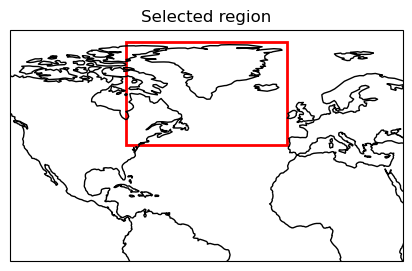

In [14]:
fig = plt.figure(figsize=(6,3))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([lon_min-50, lon_max+50, lat_min-50, lat_max+50], crs=ccrs.PlateCarree())
ax.coastlines()

import matplotlib.patches as patches
rect = patches.Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min,
                         linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

plt.title('Selected region')
plt.show()

In [15]:
fig = go.Figure(go.Scattergeo(
    lat=[lat_min, lat_max, lat_max, lat_min, lat_min],
    lon=[lon_min, lon_min, lon_max, lon_max, lon_min],
    mode='lines',
    line=dict(width=2, color='orange')
))

fig.update_geos(
    showcountries=False, countrycolor="RebeccaPurple",
    projection_type="orthographic",
    lataxis_range=[20, 90],
    lonaxis_range=[-90, 20],
    showland=True, landcolor="rgb(204, 235, 197)",
    showocean=True, oceancolor="lightblue"
)

fig.update_layout(title='Selected region (3D)', height=600, width=600)
fig.show()


In [16]:
# Extraire les coordonnées
lats = temp.variables['latitude'][:]
lons = temp.variables['longitude'][:]

# Trouver les indices correspondant à ta région
lat_inds = np.where((lats >= lat_min) & (lats <= lat_max))[0]
lon_inds = np.where((lons >= lon_min) & (lons <= lon_max))[0]

# Accéder à la variable de température
tas = temp.variables['tas_mean']  # dimensions: time, latitude, longitude

# Extraire la température dans cette région
regional_tas = tas[:, lat_inds, :][:, :, lon_inds]  # shape: (time, lat, lon)
regional_mean_tas = np.nanmean(regional_tas, axis=(1, 2))  # shape: (time,)

In [17]:
from netCDF4 import num2date

time_var = temp.variables['time']
dates = num2date(time_var[:], units=time_var.units, calendar='gregorian')  # renvoie des cftime.DatetimeGregorian

dates_ts = pd.to_datetime([pd.Timestamp(d.strftime('%Y-%m-%d')) for d in dates]) # 1850 - 2025
ts_monthly = pd.Series(regional_mean_tas, index=dates_ts)
ts_annual = ts_monthly.resample('YE').mean()  # 'YE' = fin d'année

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts_annual.index, y=ts_annual.values, mode='lines', line=dict(color='orange')))
fig.update_layout(
    title="Temperature anomaly (Greenland / North Atlantic region)",
    xaxis_title="Year",
    yaxis_title="Anomaly (°C)",
    height=400, width=600,
    plot_bgcolor='rgba(215, 238, 244, 0.3)')
fig.show()


In [19]:
temp_det = np.array(ts_annual - gaussian_filter(ts_annual, sigma=30))

In [20]:
window_length=70
window_step=1
years_1850_2024 = np.arange(1850, 2025)  # 1850 - 2024

time_windows, center_points = sw.get_centered_sliding_windows(window_length, window_step, t_len=len(years_1850_2024))

In [21]:
AC_temp = ind.regular_autocorrelation(temp_det, time_windows, lag=1, detrend=True)

In [22]:
# assuming lag 1 influence of AMOC on AMOC
graph =  np.array([[['', '-->']],], dtype='<U3')

X = [(0,-1)]
Y = [(0,0)]

causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)

causal_KNN_temp, _, _ = ind.pipeline_causalEE_weighted(
    causal_effects, temp_det.reshape(-1, 1), KNeighborsRegressor(), data_transform=StandardScaler(), n_points=150, time_windows=time_windows, var_names=[r'$Temp$'], edge_points_proportion=0.1)

In [23]:
slopeKNN, interceptKNN = np.polyfit(np.arange(len(causal_KNN_temp)), causal_KNN_temp, 1)
pvalKNN, _ = sgtest.p_value_from_fourier(causal_KNN_temp, 10000, slopeKNN)

slopeAC, interceptAC = np.polyfit(np.arange(len(AC_temp)), AC_temp, 1)
pvalAC, _ = sgtest.p_value_from_fourier(AC_temp, 10000, slopeAC)

In [24]:
fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=years_1850_2024+window_length//2, y=causal_KNN_temp,
#     mode='lines', name='temp causal KNN',
#     line=dict(color='blue')
# ))
# fig.add_trace(go.Scatter(x=years_1850_2024+window_length//2, y=slopeKNN * np.arange(len(causal_KNN_temp)) + interceptKNN, mode='lines', name=f'pv: {pvalKNN:.2f}', line=dict(color='blue', dash='dash')))


fig.add_trace(go.Scatter(
    x=years_1850_2024+window_length//2, y=AC_temp,
    mode='lines', name='AC1 T°C',
    line=dict(color='orange')
))
fig.add_trace(go.Scatter(x=years_1850_2024+window_length//2, y=slopeAC * np.arange(len(AC_temp)) + interceptAC, mode='lines', name=f'pv: {pvalAC:.2f}', line=dict(color='orange', dash='dash')))


fig.update_layout(
    xaxis_range=[1850, 2024],
    xaxis_title='Year',
    yaxis_title='AC1 T°C',
    height=400,
    width=600,
    template='simple_white',
    legend=dict(x=0.02, y=0.98)
)

fig.show()

### Salinities

In [25]:
# --- Global parameters ---
years_1900_2019 = np.arange(1900, 2020)  # data years
months = ['%02d' % m for m in range(1, 13)]
tlen = len(years_1900_2019) * 12         # total length in months
dth = 300                      # maximum depth in meters

In [26]:
# from netCDF4 import Dataset

# # --- Load dimensions from a representative NetCDF file ---
# sample_nc = Dataset('data/EN422_all/EN.4.2.2.f.analysis.g10.201811.nc')
# lat = sample_nc.variables['lat'][:]
# lon = sample_nc.variables['lon'][:]
# depth = sample_nc.variables['depth'][:]
# sample_nc.close()

# # --- Compute cosine weights for latitude-weighted averaging ---
# weights = np.cos(lat * np.pi / 180)
# dlen = np.where(depth < dth)[0].shape[0]

# # --- Initialize result arrays ---
# SNN1 = np.zeros(tlen)         # average salinity in the North Atlantic
# SNN2 = np.zeros(tlen)    # average salinity in the KLUS region

# # --- Loop over all monthly NetCDF files ---
# i = 0
# for y in years_1900_2019:
#     for m in months:
#         dat = Dataset(f'data/EN422_all/EN.4.2.2.f.analysis.g10.{y}{m}.nc')

#         # --- Average in the NA region: 44–66°N, 289–330°E ---
#         lat_mask_na = np.logical_and(lat > 44, lat < 66)
#         lon_mask_na = np.logical_or(lon > 289, lon < 330)
#         sal_temp_na = np.nanmean(dat.variables['salinity'][0, depth < dth, lat_mask_na, :][:, :, lon_mask_na], axis=2)
#         sal_temp_na = np.average(sal_temp_na, weights=weights[lat_mask_na], axis=1)
#         SNN1[i] = sal_temp_na.mean()

#         # --- Average in the KLUS region: 55–62°N, 298–334°E ---
#         lat_mask_klus = np.logical_and(lat > 55, lat < 62)
#         lon_mask_klus = np.logical_and(lon > 298, lon < 334)
#         sal_temp_klus = np.nanmean(dat.variables['salinity'][0, depth < dth, lat_mask_klus, :][:, :, lon_mask_klus], axis=2)
#         sal_temp_klus = np.average(sal_temp_klus, weights=weights[lat_mask_klus], axis=1)
#         SNN2[i] = sal_temp_klus.mean()

#         dat.close()
#         i += 1

# # --- Center the data (subtract mean) ---
# SNN1 = SNN1 - SNN1.mean()
# SNN2 = SNN2 - SNN2.mean()

# # --- Annual aggregation ---
# SNN1 = np.array([SNN1[i * 12:(i + 1) * 12].mean() for i in range(len(years))])
# SNN2 = np.array([SNN2[i * 12:(i + 1) * 12].mean() for i in range(len(years))])


In [27]:
# # --- saving ---
# np.save(f'data/EN422_NA_salinity_monthly_d{dth}.npy', SNN1)
# np.save(f'data/EN422_KLUS_salinity_monthly_d{dth}.npy', SNN2)

In [28]:
lat_na, lon_na = [44, 66], [289, 330]
lat_klus, lon_klus = [55, 62], [298, 334]

def rectangle_points(lat_bounds, lon_bounds, step_lat=1, step_lon=1.5):
    """
    Génère une grille de points à l'intérieur d'un rectangle donné.
    """
    lats = np.arange(lat_bounds[0], lat_bounds[1]+step_lat, step_lat)
    lons = np.arange(lon_bounds[0], lon_bounds[1]+step_lon, step_lon)
    grid_lats, grid_lons = np.meshgrid(lats, lons)
    return grid_lats.ravel(), grid_lons.ravel()

lats_na_pts, lons_na_pts = rectangle_points(lat_na, lon_na)

fig = go.Figure()

# North Atlantic grid points
fig.add_trace(go.Scattergeo(
    lat=lats_na_pts,
    lon=lons_na_pts,
    mode='markers',
    marker=dict(size=4, color='#00AAD4'),
    name='North Atlantic'
))

fig.update_geos(
    showcountries=False,
    showcoastlines=True,
    showland=True,
    landcolor="rgb(204, 235, 197)",
    showocean=True,
    oceancolor="lightblue",
    projection_type="orthographic",
)

fig.update_layout(
    title='North Atlantic grid points',
    legend=dict(x=0.01, y=0.99),
    height=600, width=600,
    showlegend=False,
    plot_bgcolor='rgba(215, 238, 244, 0.3)',
)

fig.show()

In [29]:
def try_open_lines(path):
    """
    Essaie d'ouvrir le fichier en UTF-8 puis en latin-1/cp1252.
    Retourne un itérable sur les lignes décodées.
    """
    # tentative utf-8
    try:
        with open(path, 'r', encoding='utf-8') as f:
            return f.readlines()
    except UnicodeDecodeError:
        pass
    # fallback latin-1
    try:
        with open(path, 'r', encoding='latin-1') as f:
            return f.readlines()
    except Exception:
        pass
    # dernier recours : ouverture en bytes puis decode avec 'replace'
    with open(path, 'rb') as f:
        raw = f.read()
    return raw.decode(errors='replace').splitlines()

float_re = re.compile(r'[-+]?\d*\.\d+|[-+]?\d+')

def read_coords(path, lon_0_to_360=False):
    """
    Lit un fichier texte et renvoie (lats, lons) comme np.array.
    - ignore les lignes vides et celles commençant par '#'
    - tolère le symbole '°' et autres caractères non numériques
    - si lon_0_to_360=True, convertit longitudes (-180..180) -> (0..360)
    """
    lines = try_open_lines(path)
    data = []
    for raw in lines:
        line = raw.strip()
        if not line or line.startswith('#'):
            continue
        # extraire tous les nombres sur la ligne
        nums = float_re.findall(line)
        if len(nums) < 2:
            # parfois la ligne contient des "lat° lon°" avec des caractères inattendus
            # on tente de nettoyer les caractères non-digit/punct et ré-essayer
            cleaned = re.sub(r'[^\d\.\-\+\s]', ' ', line)
            nums = float_re.findall(cleaned)
        if len(nums) >= 2:
            lat = float(nums[0])
            lon = float(nums[1])
            if lon_0_to_360:
                lon = lon % 360.0
            data.append((lat, lon))
        else:
            # ignorer la ligne si on ne peut pas extraire deux nombres
            continue

    if not data:
        return np.array([]), np.array([])
    arr = np.array(data)
    return arr[:,0], arr[:,1]


    lats, lons = read_coords(path_to_file, lon_0_to_360=lon_0_to_360)
    if lats.size == 0:
        raise ValueError("Aucune coordonnée lue depuis le fichier.")
    fig = go.Figure()
    fig.add_trace(go.Scattergeo(
        lat = lats,
        lon = lons,
        mode = 'markers',
        marker = dict(size=marker_size),
        name = 'grid points'
    ))


    fig.update_geos(
        showcountries=False,
        showcoastlines=True,
        showland=True,
        landcolor="rgb(204, 235, 197)",
        showocean=True,
        oceancolor="lightblue",
        projection_type="orthographic",
    )
    fig.update_layout(
        title='Points du fichier et enveloppe convexe',
        legend=dict(x=0.01, y=0.99),
        height=700, width=700,
        showlegend=True,
        plot_bgcolor='rgba(215, 238, 244, 0.3)',
    )
    fig.show()
    return fig

def plot_from_file(path_to_file, marker_size=4):
    lats, lons = read_coords(path_to_file)
    if lats.size == 0:
        raise ValueError("Aucune coordonnée lue depuis le fichier.")

    fig = go.Figure()

    # trace des points avec couleur personnalisée
    fig.add_trace(go.Scattergeo(
        lat = lats,
        lon = lons,
        mode = 'markers',
        marker = dict(size=marker_size, color='#00AAD4'),
        name = 'grid points'
    ))

    fig.update_geos(
        showcountries=False,
        showcoastlines=True,
        showland=True,
        landcolor="rgb(204, 235, 197)",
        showocean=True,
        oceancolor="lightblue",
        projection_type="orthographic",
    )

    fig.update_layout(
        title='Points du fichier',
        legend=dict(x=0.01, y=0.99),
        height=500, width=500,
        showlegend=False,
        plot_bgcolor='rgba(215, 238, 244, 0.3)',
    )

    fig.show()
    return fig


In [30]:
path = 'data/sg_grid.txt'
fig = plot_from_file(path)

In [31]:
SNN1 = np.load(f'data/EN422_NA_salinity_am_d300.npy')
SNN2 = np.load(f'data/EN422_KLUS_salinity_am_d300.npy')

SNN1_monthly = np.load(f'data/EN422_NA_salinity_monthly_d300.npy')
SNN2_monthly = np.load(f'data/EN422_KLUS_salinity_monthly_d300.npy')

In [32]:
months_1900_2019 = np.arange('1900-01', '2020-01', dtype='datetime64[M]')
months_1958_2016 = np.arange('1958-01', '2017-01', dtype='datetime64[M]')

mask = (months_1900_2019 >= np.datetime64('1958-01')) & (months_1900_2019 <= np.datetime64('2016-12'))
months_1958_2016 = months_1900_2019[mask]
SNN1_monthly_1958_2016 = SNN1_monthly[mask]
SNN2_monthly_1958_2016 = SNN2_monthly[mask]

In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=months_1958_2016, y=-SNN1_monthly_1958_2016, mode='lines', name='SNN1', line=dict(color='#2CA02C')))
fig.add_trace(go.Scatter(x=months_1958_2016, y=-SNN2_monthly_1958_2016, mode='lines', name='SNN2', line=dict(color='#5FD35F')))
fig.update_layout(
    title=f'Monthly Mean Salinity Anomalies (0–300m depth)',
    xaxis_title='Year', yaxis_title='Salinity Anomaly (psu)',
    height=500, width=1000, legend=dict(x=0.01, y=0.99), plot_bgcolor='rgba(215, 238, 244, 0.3)')
fig.show()

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=years_1900_2019, y=-SNN1, mode='lines', name='SNN1 (44–66°N, 289–330°E)', line=dict(color='#00AAD4')))
#fig.add_trace(go.Scatter(x=years_1900_2019, y=-SNN2, mode='lines', name='SNN2 (55–62°N, 298–334°E)', line=dict(color='#5FD35F')))
fig.update_layout(
    title=f'Annual Mean Salinity Anomalies (0–300m depth)',
    xaxis_title='Year',
    yaxis_title='Salinity Anomaly (psu)',
    height=400, width=600,
    legend=dict(x=0.01, y=0.99),
    plot_bgcolor='rgba(215, 238, 244, 0.3)'
)
fig.show()

In [35]:
window_length=70
window_step=1

time_windows, center_points = sw.get_centered_sliding_windows(window_length, window_step, t_len=len(years_1900_2019))

In [36]:
AC_SNN1 = ind.regular_autocorrelation(SNN1, time_windows, lag=1, detrend=True)
AC_SNN2 = ind.regular_autocorrelation(SNN2, time_windows, lag=1, detrend=True)

In [37]:
slopeAC_SNN1, interceptAC_SNN1 = np.polyfit(np.arange(len(AC_SNN1)), AC_SNN1, 1)
pvalAC_SNN1, _ = sgtest.p_value_from_fourier(AC_SNN1, 10000, slopeAC_SNN1)

slopeAC_SNN2, interceptAC_SNN2 = np.polyfit(np.arange(len(AC_SNN2)), AC_SNN2, 1)
pvalAC_SNN2, _ = sgtest.p_value_from_fourier(AC_SNN2, 10000, slopeAC_SNN2)

In [38]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=years_1900_2019+window_length//2, y=AC_SNN1, mode='lines', name='AC SNN1', line=dict(color='#2CA02C')))
fig.add_trace(go.Scatter(x=years_1900_2019+window_length//2, y=slopeAC_SNN1 * np.arange(len(AC_SNN1)) + interceptAC_SNN1, mode='lines', name=f'pv: {pvalAC_SNN1:.2f}', line=dict(color='#2CA02C', dash='dash')))

fig.add_trace(go.Scatter(x=years_1900_2019+window_length//2, y=AC_SNN2, mode='lines', name='AC SNN2', line=dict(color='#5FD35F')))
fig.add_trace(go.Scatter(x=years_1900_2019+window_length//2, y=slopeAC_SNN2 * np.arange(len(AC_SNN2)) + interceptAC_SNN2, mode='lines', name=f'pv: {pvalAC_SNN2:.2f}', line=dict(color='#5FD35F', dash='dash')))

fig.update_layout(xaxis_range=[1900, 2020], xaxis_title='Years', yaxis_title='AC1 salinities', height=400, width=600, template='simple_white', legend=dict(x=0.02, y=0.99))
fig.show()

### Freshwater input

In [39]:
# Freshwater
ds = xr.open_dataset("data/FWF17.v3_b.nc")
#ds

In [40]:
# Create a mask for the North Atlantic Ocean
north_atlantic_id = 76
north_atlantic_mask = ds['ocean_basins'] == north_atlantic_id

In [41]:
# Apply the mask to select data only for the North Atlantic Ocean
gr_tundra_runoff_na = ds['runoff_tundra'].where(north_atlantic_mask, 0).where(ds['LSMGr'] == 1, 0)
gr_runoff_ice_na = ds['runoff_ice'].where(north_atlantic_mask, 0).where(ds['LSMGr'] == 1, 0)
gr_solid_ice_na = ds['solid_ice'].where(north_atlantic_mask, 0).where(ds['LSMGr'] == 1, 0) 

tundra_runoff_na = ds['runoff_tundra'].where(north_atlantic_mask, 0)
runoff_ice_na = ds['runoff_ice'].where(north_atlantic_mask, 0)
solid_ice_na = ds['solid_ice'].where(north_atlantic_mask, 0)

In [42]:
gr_freshwater_monthly = (gr_tundra_runoff_na + gr_runoff_ice_na + gr_solid_ice_na).sum(dim=["X", "Y"])
months_1958_2016 = gr_freshwater_monthly['TIME']
freshwater_monthly = (tundra_runoff_na + runoff_ice_na + solid_ice_na).sum(dim=["X", "Y"])

In [43]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=months_1958_2016, y=freshwater_monthly, mode='lines', name='total FWF', line=dict(color='#2CA02C')))
fig.add_trace(go.Scatter(x=months_1958_2016, y=gr_freshwater_monthly, mode='lines', name='GrIS FWF', line=dict(color='#5FD35F')))
fig.update_layout(
    title='Monthly freshwater flux in the North Atlantic',
    xaxis_title='Year',
    yaxis_title='Freshwater Flux',
    height=500, width=1000,
    legend=dict(x=0.01, y=0.99),
    plot_bgcolor='rgba(215, 238, 244, 0.3)'
)
fig.show()


In [44]:
# Sum over the spatial dimensions (X, Y) for each month, then resample by year to sum monthly values
gr_runoff_tundra_yearly = gr_tundra_runoff_na.sum(dim=["X", "Y"]).resample(TIME="YE").sum()
gr_runoff_ice_yearly = gr_runoff_ice_na.sum(dim=["X", "Y"]).resample(TIME="YE").sum()
gr_solid_ice_yearly = gr_solid_ice_na.sum(dim=["X", "Y"]).resample(TIME="YE").sum()

runoff_tundra_yearly = tundra_runoff_na.sum(dim=["X", "Y"]).resample(TIME="YE").sum()
runoff_ice_yearly = runoff_ice_na.sum(dim=["X", "Y"]).resample(TIME="YE").sum()
solid_ice_yearly = solid_ice_na.sum(dim=["X", "Y"]).resample(TIME="YE").sum()

In [45]:
gr_total_freshwater = gr_runoff_tundra_yearly + gr_runoff_ice_yearly + gr_solid_ice_yearly
years_1958_2016 = gr_total_freshwater['TIME']
total_freshwater = runoff_tundra_yearly + runoff_ice_yearly + solid_ice_yearly

fig = go.Figure()
fig.add_trace(go.Scatter(x=years_1958_2016, y=total_freshwater, mode='lines', name='Total FWF', line=dict(color='#2CA02C')))
#fig.add_trace(go.Scatter(x=years_1958_2016, y=gr_total_freshwater, mode='lines', name='GrIS FWF', line=dict(color='#5FD35F')))
fig.update_layout(plot_bgcolor='rgba(215, 238, 244, 0.3)', width=600,height=400, xaxis_title='Year', yaxis_title='FWF into the NA (km3)', legend=dict(x=0.01, y=0.98))

In [46]:
years_1958_2016 = np.array([pd.Timestamp(year).year for year in years_1958_2016.values])

In [47]:
window_length=30
window_step=1
time_windows, center_points = sw.get_centered_sliding_windows(window_length, window_step, t_len=len(years_1958_2016))

In [48]:
AC_totalFWF = ind.regular_autocorrelation(total_freshwater, time_windows, lag=1, detrend=True)
slopeAC_FWF, interceptAC_FWF = np.polyfit(np.arange(len(AC_totalFWF)), AC_totalFWF, 1)
pvalAC_FWF, _ = sgtest.p_value_from_fourier(AC_totalFWF, 10000, slopeAC_FWF)

In [49]:
AC_grFWF = ind.regular_autocorrelation(gr_total_freshwater, time_windows, lag=1, detrend=True)
slopeAC_grFWF, interceptAC_grFWF = np.polyfit(np.arange(len(AC_grFWF)), AC_grFWF, 1)
pvalAC_grFWF, _ = sgtest.p_value_from_fourier(AC_grFWF, 10000, slopeAC_grFWF)

In [50]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=years_1958_2016+window_length//2, y=AC_totalFWF, mode='lines', name='total FWF', line=dict(color='#2CA02C')))
fig.add_trace(go.Scatter(x=years_1958_2016+window_length//2, y=slopeAC_FWF * np.arange(len(AC_totalFWF)) + interceptAC_FWF, mode='lines', name=f'pv: {pvalAC_FWF:.2f}', line=dict(color='#2CA02C', dash='dash')))

fig.add_trace(go.Scatter(x=years_1958_2016+window_length//2, y=AC_grFWF, mode='lines', name='GrIS FWF', line=dict(color='#5FD35F')))
fig.add_trace(go.Scatter(x=years_1958_2016+window_length//2, y=slopeAC_grFWF * np.arange(len(AC_grFWF)) + interceptAC_grFWF, mode='lines', name=f'pv: {pvalAC_grFWF:.2f}', line=dict(color='#5FD35F', dash='dash')))

fig.update_layout(xaxis_range = [1958, 2017], width=600,height=400, xaxis_title='Year', yaxis_title='AC1 FWF into the NA', legend=dict(x=0.01, y=0.99), template='simple_white')

In [51]:
wl_list=[20, 30, 40]
window_step=1
nb_surrogates=10000

fig= go.Figure()
for wl in wl_list:
    time_windows, center_points = sw.get_centered_sliding_windows(wl, window_step, t_len=len(years_1958_2016))
    AC_totalFWF_wl = ind.regular_autocorrelation(total_freshwater, time_windows, lag=1, detrend=True)
    slopeAC_FWF_wl, interceptAC_FWF_wl = np.polyfit(np.arange(len(AC_totalFWF_wl)), AC_totalFWF_wl, 1)
    pvalAC_FWF_wl, _ = sgtest.p_value_from_fourier(AC_totalFWF_wl, nb_surrogates, slopeAC_FWF_wl)

    fig.add_trace(go.Scatter(x=years_1958_2016+wl//2, y=AC_totalFWF_wl, mode='lines', name=f'wl={wl}', line=dict(color='#2CA02C', dash='dashdot' if wl==20 else 'solid' if wl==30 else 'dot')))
    fig.add_trace(go.Scatter(x=years_1958_2016+wl//2, y=slopeAC_FWF_wl * np.arange(len(AC_totalFWF_wl)) + interceptAC_FWF_wl, mode='lines', name=f'pv: {pvalAC_FWF_wl:.2f}', line=dict(color="#2CA02C", dash='dashdot' if wl==20 else 'solid' if wl==30 else 'dot'), opacity=0.5))


fig.update_layout(xaxis_range = [1958, 2017], width=600,height=400, xaxis_title='Year', yaxis_title='AC1 total FWF into the NA', legend=dict(x=0.01, y=1), template='simple_white')

### AMOC Ditlevsen

In [52]:
# monthly from 1870 to 2020
ditlevsen = pd.read_csv("data/AMOCdata.txt", sep=' ')
#ditlevsen

In [53]:
AMOC_ditlevsen_monthly_1958_2016 = ditlevsen[(ditlevsen['time'] < 2017) & (ditlevsen['time'] >= 1958)]['AMOC2']

In [54]:
filtered_ditlevsen = ditlevsen[(ditlevsen['time'] >= 1871) & (ditlevsen['time'] <= 2016)].copy()
filtered_ditlevsen['year'] = filtered_ditlevsen['time'].astype(int)
AMOC_ditlevsen_yearly_1871_2016 = filtered_ditlevsen.groupby('year')['AMOC2'].mean()
AMOC_ditlevsen_yearly_1871_2016.name = 'AMOC'

### Preprocessing

In [55]:
sigma = 30

AMOC_Caesar = df_1871_2013["AMOC_Caesar"].values
AMOC_Caesar_det = AMOC_Caesar - gaussian_filter(AMOC_Caesar, sigma=sigma)
AMOC_Ditlevsen = AMOC_ditlevsen_yearly_1871_2016.values
AMOC_Ditlevsen_det = AMOC_Ditlevsen - gaussian_filter(AMOC_Ditlevsen, sigma=sigma)

CWG = df_1871_2013["CWG"].values
CWG_det = CWG - gaussian_filter(CWG, sigma=sigma)
CWG_log = np.log(CWG + np.abs(CWG.min()) + 1)
CWG_log_det = CWG_log - gaussian_filter(CWG_log, sigma=sigma)

NU = df_1871_2013["NU"].values
NU_det = NU - gaussian_filter(NU, sigma=sigma)
NU_log = np.log(NU + np.abs(NU.min()) + 1)
NU_log_det = NU_log - gaussian_filter(NU_log, sigma=sigma)

SNN1_det = SNN1 - gaussian_filter(SNN1, sigma=sigma)
SNN2_det = SNN2 - gaussian_filter(SNN2, sigma=sigma)

## AMOC

In [56]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=[i for i in range(1871, 2016)], y=AMOC_Caesar, mode='lines', name='Caesar index (°C)', line=dict(color='#00AAD4')))
#fig.add_trace(go.Scatter(x=[i for i in range(1871, 2016)], y=AMOC_Ditlevsen_det, mode='lines', name='Ditlevsen index', line=dict(color='#2AD4FF')))
fig.update_layout(plot_bgcolor='rgba(215, 238, 244, 0.3)',width=600,height=400, xaxis_title='Year', yaxis_title='Caesar index (°C)',
                  legend=dict(x=0.01, y=0.03))

In [57]:
window_length=70
window_step=1
years_1871_2013 = np.arange(1871, 2014)  # 1871 - 2013
years_1871_2016 = np.arange(1871, 2017)  # 1871 - 2016

In [58]:
time_windows, center_points = sw.get_centered_sliding_windows(window_length, window_step, t_len=len(years_1871_2013))
AC_Caesar = ind.regular_autocorrelation(AMOC_Caesar_det, time_windows, lag=1, detrend=True)

slopeAC_Caesar, interceptAC_Caesar = np.polyfit(np.arange(len(AC_Caesar)), AC_Caesar, 1)
pvalAC_Caesar, _ = sgtest.p_value_from_fourier(AC_Caesar, 10000, slopeAC_Caesar)

In [59]:
time_windows, center_points = sw.get_centered_sliding_windows(window_length, window_step, t_len=len(years_1871_2016))
AC_Ditlevsen = ind.regular_autocorrelation(AMOC_Ditlevsen_det, time_windows, lag=1, detrend=True)

slopeAC_Ditlevsen, interceptAC_Ditlevsen = np.polyfit(np.arange(len(AC_Ditlevsen)), AC_Ditlevsen, 1)
pvalAC_Ditlevsen, _ = sgtest.p_value_from_fourier(AC_Ditlevsen, 10000, slopeAC_Ditlevsen)

In [60]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=years_1871_2013+window_length//2, y=AC_Caesar, mode='lines', name='AC1 Caesar index', line=dict(color='#00AAD4')))
fig.add_trace(go.Scatter(x=years_1871_2013+window_length//2, y=slopeAC_Caesar * np.arange(len(AC_Caesar)) + interceptAC_Caesar, mode='lines', name=f'pv: {pvalAC_Caesar:.2f}', line=dict(color='#00AAD4', dash='dash')))

fig.add_trace(go.Scatter(x=years_1871_2016+window_length//2, y=AC_Ditlevsen, mode='lines', name='AC1 Ditlevsen index', line=dict(color='#2AD4FF')))
fig.add_trace(go.Scatter(x=years_1871_2016+window_length//2, y=slopeAC_Ditlevsen * np.arange(len(AC_Ditlevsen)) + interceptAC_Ditlevsen, mode='lines', name=f'pv: {pvalAC_Ditlevsen:.2f}', line=dict(color='#2AD4FF', dash='dash')))

fig.update_layout(xaxis_range = [1871, 2016], width=600,height=400, xaxis_title='Year', yaxis_title='AC1 AMOC index',
                  legend=dict(x=0.01, y=0.99), template='simple_white')

## CWG-NU melt rates

In [61]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=list(range(1871, 2013)),y=CWG_log,mode='lines',name='CWG (log)',line=dict(color='#2CA02C')),secondary_y=False)
fig.add_trace(go.Scatter(x=list(range(1871, 2013)),y=CWG,mode='lines',name='CWG (z-scores)',line=dict(color='#5FD35F')),secondary_y=True)

fig.update_layout(plot_bgcolor='rgba(215, 238, 244, 0.3)',width=630,height=400,xaxis_title='Year',legend=dict(x=0.01, y=0.98))
fig.update_yaxes(title_text='CWG melt rates (log)', secondary_y=False)
fig.update_yaxes(title_text='CWG melt rates (z-scores)', secondary_y=True)

fig.show()


In [62]:
window_length=70
window_step=1
time_windows, center_points = sw.get_centered_sliding_windows(window_length, window_step, t_len=len(years_1871_2013))

In [63]:
AC_CWG_log = ind.regular_autocorrelation(CWG_log_det, time_windows, lag=1, detrend=True)
slopeAC_CWG, interceptAC_CWG = np.polyfit(np.arange(len(AC_CWG_log)), AC_CWG_log, 1)
pvalAC_CWG, _ = sgtest.p_value_from_fourier(AC_CWG_log, 10000, slopeAC_CWG)

In [64]:
AC_NU_log = ind.regular_autocorrelation(NU_log_det, time_windows, lag=1, detrend=True)
slopeAC_NU_log, interceptAC_NU_log = np.polyfit(np.arange(len(AC_NU_log)), AC_NU_log, 1)
pvalAC_NU_log, _ = sgtest.p_value_from_fourier(AC_NU_log, 10000, slopeAC_NU_log)

In [65]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=years_1871_2013+window_length//2, y=AC_CWG_log, mode='lines', name='AC1 CWG', line=dict(color='#00AAD4')))
fig.add_trace(go.Scatter(x=years_1871_2013+window_length//2, y=slopeAC_CWG * np.arange(len(AC_CWG_log)) + interceptAC_CWG, mode='lines', name=f'pv: {pvalAC_CWG:.2f}', line=dict(color='#00AAD4', dash='dash')))

fig.add_trace(go.Scatter(x=years_1871_2013+window_length//2, y=AC_NU_log, mode='lines', name='AC1 NU', line=dict(color='#2AD4FF')))
fig.add_trace(go.Scatter(x=years_1871_2013+window_length//2, y=slopeAC_NU_log * np.arange(len(AC_NU_log)) + interceptAC_NU_log, mode='lines', name=f'pv: {pvalAC_NU_log:.2f}', line=dict(color='#2AD4FF', dash='dash')))
    
fig.update_layout(xaxis_range = [1871, 2016], width=600,height=400, xaxis_title='Year', yaxis_title='AC1 GrIS melt rates',
                  legend=dict(x=0.01, y=0.99), template='simple_white')

# Investigating causal relationships

### Which graph is the most plausible given the data?

In [64]:
AMOC_proxy = -SNN2[:-6]    # 1900-2019
GIS_proxy = CWG_log_det[29:]     # 1871-2013
Temp_proxy = np.array(ts_annual[50:-12])    # 1850-2025

In [65]:
len(AMOC_proxy), len(GIS_proxy), len(Temp_proxy)

(114, 114, 114)

In [66]:
dataframe = np.hstack([Temp_proxy.reshape(-1,1), 
                       GIS_proxy.reshape(-1,1), 
                       AMOC_proxy.reshape(-1,1)])

In [67]:
model = CMIknn(knn=5, transform=None)

In [68]:
pcmci = PCMCI(
    dataframe=pp.DataFrame(dataframe, var_names=["Temp", "GIS", "AMOC"]),
    cond_ind_test=model,
    verbosity=0
)

/opt/anaconda3/envs/tigramite_env/lib/python3.10/site-packages/tigramite/plotting.py:3397: RuntimeWarning:

invalid value encountered in double_scalars



KeyboardInterrupt: 

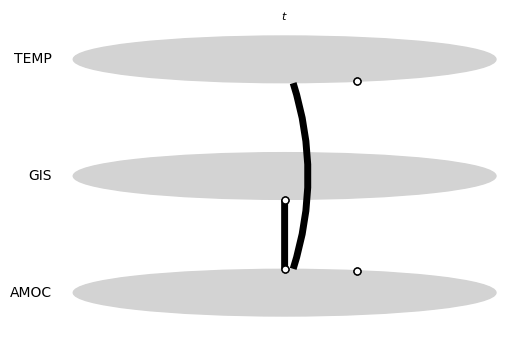

In [69]:
# Paramètres de base
lag_range = range(0, 11)  # tau_max de 0 à 10
var_names = ['TEMP', 'GIS', 'AMOC']  # à adapter
N = len(var_names)
alpha = 0.05  # niveau de signification pour le test d'hypothèse

for idx, tau_max in enumerate(lag_range):
    result = pcmci.get_lagged_dependencies(
        tau_min=0,
        tau_max=tau_max,
        val_only=False,
        alpha_level=alpha,
        fdr_method='fdr_bh'
    )
    p_matrix = result['p_matrix']
    graph = result['graph']

    plot_graph(
        graph=graph,
        var_names=var_names,
        node_size=0.2,
        arrow_linewidth=5,
        figsize=(6, 4),  # still required even if ax is implicitly used
    )
    #ax.set_title(f"tau_max = {tau_max}", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
idx_GrIS = 0
idx_AMOC = 1

results = []

for tau_max in lag_range:
    result = pcmci.get_lagged_dependencies(
        tau_min=0,
        tau_max=tau_max,
        val_only=False,
        alpha_level=0.05,
        fdr_method='fdr_bh'
    )
    val_matrix = result['val_matrix']
    
    # Extract relevant slices (lags from 0 to tau_max)
    # val_matrix shape : (n_vars, n_vars, tau_max+1)
    
    # GrIS → GrIS
    vals_GrIS_GrIS = val_matrix[idx_GrIS, idx_GrIS, :tau_max+1]
    lag_max_GrIS_GrIS = np.abs(vals_GrIS_GrIS).argmax()
    val_max_GrIS_GrIS = vals_GrIS_GrIS[lag_max_GrIS_GrIS]
    
    # AMOC → AMOC
    vals_AMOC_AMOC = val_matrix[idx_AMOC, idx_AMOC, :tau_max+1]
    lag_max_AMOC_AMOC = np.abs(vals_AMOC_AMOC).argmax()
    val_max_AMOC_AMOC = vals_AMOC_AMOC[lag_max_AMOC_AMOC]
    
    # GrIS → AMOC
    vals_GrIS_AMOC = val_matrix[idx_AMOC, idx_GrIS, :tau_max+1]
    lag_max_GrIS_AMOC = np.abs(vals_GrIS_AMOC).argmax()
    val_max_GrIS_AMOC = vals_GrIS_AMOC[lag_max_GrIS_AMOC]
    
    results.append({
        "tau_max": tau_max,
        "lag_max_GrIS_GrIS": lag_max_GrIS_GrIS,
        "val_max_GrIS_GrIS": val_max_GrIS_GrIS,
        "lag_max_AMOC_AMOC": lag_max_AMOC_AMOC,
        "val_max_AMOC_AMOC": val_max_AMOC_AMOC,
        "lag_max_GrIS_AMOC": lag_max_GrIS_AMOC,
        "val_max_GrIS_AMOC": val_max_GrIS_AMOC
    })

df_results = pd.DataFrame(results)
print(df_results)


    tau_max  lag_max_GrIS_GrIS  val_max_GrIS_GrIS  lag_max_AMOC_AMOC  \
0         0                  0           0.000000                  0   
1         1                  1           0.510231                  1   
2         2                  1           0.501229                  1   
3         3                  1           0.500016                  1   
4         4                  1           0.472895                  1   
5         5                  1           0.491185                  1   
6         6                  1           0.501893                  1   
7         7                  1           0.486200                  1   
8         8                  1           0.481111                  1   
9         9                  1           0.487454                  1   
10       10                  1           0.449571                  1   

    val_max_AMOC_AMOC  lag_max_GrIS_AMOC  val_max_GrIS_AMOC  
0            0.000000                  0          -0.047879  
1          

# AMOC (Caesar) and FWF

In [ ]:
years_1958_2013 = years_1958_2016[:-3]
t_len = len(years_1958_2013)
t_len

NameError: name 'years_1958_2016' is not defined

In [ ]:
window_length = 40
window_step = 1

time_windows, center_points = sw.get_centered_sliding_windows(window_length, window_step, t_len)

: 

: 

In [ ]:
n_points=150

: 

: 

## AMOC only

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=[i for i in range(1871, 2016)], y=AMOC_Caesar, mode='lines', name='AMOC (Caesar proxy)', line=dict(color='#00CCFF')))
fig.update_layout(plot_bgcolor='rgba(215, 238, 244, 0.3)',width=800,height=400, xaxis_title='Year', yaxis_title='AMOC (Caesar proxy, °C)')

: 

: 

In [ ]:
lags = range(1, 11)  # Lags from 1 to 10
autocorrelations = [np.corrcoef(AMOC_Caesar[:-lag], AMOC_Caesar[lag:])[0, 1] for lag in lags]

df = pd.DataFrame({
    "Lag": lags,
    "Autocorrelation": autocorrelations
})

fig = px.scatter(
    df, 
    x="Lag", 
    y="Autocorrelation", 
    title="Autocorrelations at different lags", 
    labels={"Lag": "Lag", "Autocorrelation": "Autocorrelation"},
    template="plotly_white",
    width=800, height=400
)

fig.update_traces(marker=dict(size=10, color='blue'))
fig.show()

: 

: 

In [ ]:
detrend = True
regAC_1958 = ind.regular_autocorrelation(AMOC_Caesar_det.values, time_windows, lag=1, detrend=detrend)

: 

: 

## AMOC only

In [ ]:
len(data_det_freshwater[:, 2:])

57

: 

: 

In [ ]:
# assuming lag 1 influence of AMOC on AMOC
graph =  np.array([[['', '-->']],], dtype='<U3')

X = [(0,-1)]
Y = [(0,0)]

causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)

: 

: 

In [ ]:
largest_slopes, fig = plot_window_length_analysis(causal_effects, data_det_freshwater[:, 2:], var_names=['AMOC_Caesar'], time_windows=time_windows, rows=3, cols=6, 
                                           n_points=n_points, estimator=KNeighborsRegressor(), data_transform=StandardScaler(), edge_points_proportion=0.1)

: 

: 

In [ ]:
causal_KNN_det_total_freshwater_g1, residuals_det_total_freshwater, std_devs_det_total_freshwater = ind.pipeline_causalEE_weighted(
    causal_effects, data_det_freshwater[:, 2:], KNeighborsRegressor(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$AMOC$'], edge_points_proportion=0.3)
causal_LinReg_det_total_freshwater_g1, residuals_det_total_freshwater, std_devs_det_total_freshwater = ind.pipeline_causalEE_weighted(
    causal_effects, data_det_freshwater[:, 2:], LinearRegression(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$AMOC$'], edge_points_proportion=0.3)

: 

: 

## GIS only

In [ ]:
# assuming lag 1 influence of GIS on GIS
graph =  np.array([[['', '-->']],], dtype='<U3')

X = [(0,-1)]
Y = [(0,0)]

causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)

: 

: 

In [ ]:
largest_slopes, fig = plowindow_length_analysis(causal_effects, data_det_freshwater[:, 1].reshape(-1, 1), var_names=[r'total_freshwater'], time_windows=time_windows, rows=3, cols=6, 
                                           n_points=n_points, estimator=KNeighborsRegressor(), data_transform=StandardScaler(), edge_points_proportion=0.1)

: 

: 

In [ ]:
causal_KNN_det_total_freshwater, _, _ = ind.pipeline_causalEE_weighted(
    causal_effects, data_det_freshwater[:, 1].reshape(-1, 1), KNeighborsRegressor(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$total_freshwater$'], edge_points_proportion=0.1)
causal_LinReg_det_total_freshwater, _, _ = ind.pipeline_causalEE_weighted(
    causal_effects, data_det_freshwater[:, 1].reshape(-1, 1), LinearRegression(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$total_freshwater$'], edge_points_proportion=0.1)

: 

: 

## AMOC and GrIS

### GrIS: NA_FWF

In [ ]:
lags = range(1, 11)  # Lags de 1 à 10
autocorrelations = [np.corrcoef(total_freshwater[:-lag], total_freshwater[lag:])[0, 1] for lag in lags]

# Préparer les données pour Plotly
df = pd.DataFrame({
    "Lag": lags,
    "Autocorrelation": autocorrelations
})

# Créer le scatter plot
fig = px.scatter(
    df, 
    x="Lag", 
    y="Autocorrelation", 
    title="Autocorrelations at different lags", 
    labels={"Lag": "Lag", "Autocorrelation": "Autocorrelation"},
    template="plotly_white",
    width=800, height=400
)

fig.update_traces(marker=dict(size=10, color='blue'))  # Ajuster la taille et couleur des points
fig.show()

: 

: 

### Cross correlation between AMOC and GrIS

In [ ]:
lags = range(-10, 11)

cross_correlations = []
for lag in lags:
    if lag < 0:
        corr = np.corrcoef(total_freshwater[-lag:], AMOC_Caesar[84:][:lag])[0, 1] if -lag < len(total_freshwater) else None
    elif lag > 0:
        corr = np.corrcoef(total_freshwater[:-lag], AMOC_Caesar[84:][lag:])[0, 1] if lag < len(total_freshwater) else None
    else:  # lag == 0
        corr = np.corrcoef(total_freshwater, AMOC_Caesar[84:])[0, 1]
    cross_correlations.append(corr)

df = pd.DataFrame({
    "Lag": lags,
    "Cross-Correlation": cross_correlations
})

fig = px.scatter(
    df, 
    x="Lag", 
    y="Cross-Correlation", 
    title="Cross-Correlations Between AMOC (Caesar) and GrIS (FWF) at Lags -10 to +10",
    labels={"Lag": "Lag", "Cross-Correlation": "Cross-Correlation"},
    template="plotly_white"
)

fig.update_traces(marker=dict(size=10, color='purple'))

fig.update_layout(
    width=800,
    height=400
)

fig.show()

: 

: 

## causal effect of GrIS on AMOC

In [ ]:
# assuming lag 2 influence of GrIS on AMOC, and lag1 influence on GrIS-GrIS/AMOC-AMOC
graph =  np.array([[['', '-->', ''], ['', '', '-->']],
            [['', '', ''], ['', '-->', '']],], dtype='<U3')

X = [(0,-2)]
Y = [(1,0)]

causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)

: 

: 

In [ ]:
dataframe = pp.DataFrame(data_det_freshwater[:, 1:], var_names = ['total_freshwater', 'AMOC_Caesar'])

: 

: 

In [ ]:
# on whole data
causal_effects.fit_total_effect(
        dataframe=dataframe, 
        estimator=KNeighborsRegressor(),
        adjustment_set='optimal',
        conditional_estimator=None,  
        data_transform=StandardScaler(),
        mask_type=None,
        )

intervention_data, intervention_data_here = ind.produce_intervention_data(data_det_freshwater[:, 1], 0.01, 100)

estimated_causal_effects = causal_effects.predict_total_effect( 
intervention_data=intervention_data_here,
transform_interventions_and_prediction=True,)

slope, intercept = np.polyfit(intervention_data, estimated_causal_effects, 1)
pvCWG, _ = sgtest.p_value_from_fourier(estimated_causal_effects, 1000, slope)

fig = go.Figure()
fig.add_trace(go.Scatter(x=intervention_data, y=estimated_causal_effects, mode='markers', name='Estimated Causal Effects', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=intervention_data, y=slope*intervention_data + intercept, mode='lines', line=dict(color='blue', dash="dot",), name=f'slope = {slope: .3f}', ))

fig.update_layout(width=800, height=400, xaxis_title='Intervention data', yaxis_title='Estimated Causal Effect', 
                  legend=dict(x=0.35, y=0.95,xanchor='right',  yanchor='top',   bgcolor='rgba(255, 255, 255, 0.5)',)
)

: 

: 

In [ ]:
# on windows
causal_KNN_GIS_on_AMOC, _, _ = ind.pipeline_causalEE_weighted(
    causal_effects, data_det_freshwater[:, 1:], KNeighborsRegressor(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$total_freshwater$', r'$AMOC$'], edge_points_proportion=0.1)
causal_Linreg_GIS_on_AMOC, _, _ = ind.pipeline_causalEE_weighted(
    causal_effects, data_det_freshwater[:, 1:], LinearRegression(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$total_freshwater$', r'$AMOC$'], edge_points_proportion=0.1)

: 

: 

In [ ]:
years_numeric = pd.to_datetime(years_1958_2016).year
start_index = window_length // 2
end_index = len(years_numeric) - (window_length // 2)
x = years_numeric[start_index:end_index]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y = causal_KNN_GIS_on_AMOC, mode='lines', name='KNN', line=dict(color='#00CCFF')))
fig.add_trace(go.Scatter(x=x, y = causal_Linreg_GIS_on_AMOC, mode='lines', name='LinReg', line=dict(color='#00AAD4')))
fig.update_layout(plot_bgcolor='rgba(215, 238, 244, 0.3)', width=800, height=400, xaxis=dict(range=[years_numeric[0], years_numeric[-1]], title='Year'), yaxis_title='Causal effect of GrIS on AMOC',
                                    legend=dict(x=0.95, y=0.35, xanchor='right', yanchor='top', bgcolor='rgba(255, 255, 255, 0.5)',))
fig.show()

: 

: 

## CSD analysis

In [ ]:
# # assuming lag 5 influence of GrIS on AMOC, and lag1 influence on GrIS-GrIS/AMOC-AMOC
# graph =  np.array([[['', '-->', '', '', '', ''], ['', '', '', '', '', '-->']],
#             [['', '', '', '', '', ''], ['', '-->', '', '', '', '']],], dtype='<U3')

# assuming lag 2 influence of GrIS on AMOC, and lag1 influence on GrIS-GrIS/AMOC-AMOC
graph =  np.array([[['', '-->', ''], ['', '', '-->']],
            [['', '', ''], ['', '-->', '']],], dtype='<U3')

X = [(1,-1)]
Y = [(1,0)]

causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)

: 

: 

In [ ]:
n_points=150

: 

: 

In [ ]:
window_length = 40
time_windows, center_points = sw.get_centered_sliding_windows(window_length, window_step, t_len)

: 

: 

In [ ]:
largest_slopes, fig = plowindow_length_analysis(causal_effects, data_det_freshwater[:, 1:], var_names=[r'$total_freshwater$', r'$AMOC$'], time_windows=time_windows, rows=3, cols=6, 
                                           n_points=n_points, estimator=KNeighborsRegressor(), data_transform=StandardScaler(), edge_points_proportion=0.05)

: 

: 

In [ ]:
regAC_1958 = ind.regular_autocorrelation(data_det_freshwater[:, 2], time_windows, lag=1, detrend=detrend)

: 

: 

In [ ]:
# freshwater
total_AC = ind.regular_autocorrelation(data_det_freshwater[:, 1], time_windows, lag=1, detrend=True)
solid_ice_AC = ind.regular_autocorrelation(solid_ice_det, time_windows, lag=1, detrend=True)

: 

: 

In [ ]:
causal_KNN_nondet_total_freshwater, residuals_nondet_total_freshwater, std_devs_nondet_total_freshwater = ind.pipeline_causalEE_weighted(
    causal_effects, data_concatenated_freshwater[:, 1:], KNeighborsRegressor(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$total_freshwater$', r'$AMOC$'], edge_points_proportion=0.05)
causal_KNN_det_total_freshwater_lag, residuals_det_total_freshwater, std_devs_det_total_freshwater = ind.pipeline_causalEE_weighted(
    causal_effects, data_det_freshwater[:, 1:], KNeighborsRegressor(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$total_freshwater$', r'$AMOC$'], edge_points_proportion=0.05)

causal_LinReg_det_total_freshwater_lag, residuals_det_total_freshwater, std_devs_det_total_freshwater = ind.pipeline_causalEE_weighted(
    causal_effects, data_det_freshwater[:, 1:], LinearRegression(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$total_freshwater$', r'$AMOC$'], edge_points_proportion=0.05)

: 

: 

In [ ]:
years_numeric = pd.to_datetime(years_1958_2013).year
plot_results(regAC_1958, total_AC, causal_KNN_det_total_freshwater, causal_KNN_det_total_freshwater_g1, causal_KNN_det_total_freshwater_lag, causal_LinReg_det_total_freshwater, causal_LinReg_det_total_freshwater_g1, causal_LinReg_det_total_freshwater_lag, years_numeric, window_length=window_length, nb_surrogates=10000)

NameError: name 'plot_results' is not defined

: 

: 

# Arctic summer temperature

In [ ]:
t_len = len(years_1871_2013)
window_length = 30
window_step = 1
time_windows, center_points = sw.get_centered_sliding_windows(window_length, window_step, t_len)

jja_AC = ind.regular_autocorrelation(jja_det.values, time_windows, lag=1, detrend=True)

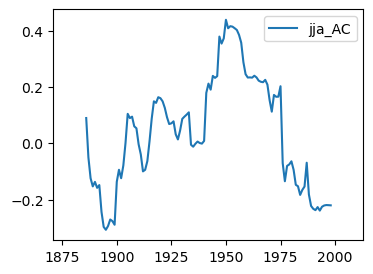

In [ ]:
plt.figure(figsize=(4, 3))
start_index = window_length // 2
end_index = len(years_1871_2013) - (window_length // 2)
x = years_1871_2013[start_index:end_index]

plt.plot(x, jja_AC, label='jja_AC')
plt.xlim(years_1871_2013[0], years_1871_2013[-1])
plt.legend()

### Graph
Let's assume the arctic temperature has a direct and contemporaneous effect on both the GrIS and the AMOC

In [ ]:
graph =  np.array([[['', '-->' ], ['-->', ''], ['-->', '']],
                   [['<--', '' ], ['', '-->'], ['', '-->']],
            [['<--', '' ], ['', ''], ['', '-->']],], dtype='<U3')

X = [(2,-1)]
Y = [(2,0)]

causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)

In [ ]:
years_1958_2013 = years_1958_2016[:-3]
t_len = len(years_1958_2013)

In [ ]:
regAC = ind.regular_autocorrelation(AMOC_Caesar_det.values, time_windows, lag=1, detrend=detrend)
total_AC = ind.regular_autocorrelation(total_freshwater.values, time_windows, lag=1, detrend=True)
jja_AC = ind.regular_autocorrelation(jja_det.values, time_windows, lag=1, detrend=True)

In [ ]:
causal_KNN_nondet_total_freshwater, residuals_nondet_total_freshwater, std_devs_nondet_total_freshwater = ind.pipeline_causalEE_weighted(causal_effects, data_concatenated_freshwater, KNeighborsRegressor(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$JJA$'r'$total_freshwater$', r'$AMOC$'], edge_points_proportion=0.05)
causal_KNN_det_total_freshwater_g3, residuals_det_total_freshwater, std_devs_det_total_freshwater = ind.pipeline_causalEE_weighted(causal_effects, data_det_freshwater, KNeighborsRegressor(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$JJA$'r'$total_freshwater$', r'$AMOC$'], edge_points_proportion=0.05)

In [ ]:
causal_KNN_nondet_solid_ice, residuals_nondet_solid_ice, std_devs_nondet_solid_ice = ind.pipeline_causalEE_weighted(causal_effects, data_concatenated_solid_ice, KNeighborsRegressor(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$JJA$', r'$solid_ice$', r'$AMOC$'], edge_points_proportion=0.05)
causal_KNN_det_solid_ice, residuals_det_solid_ice, std_devs_det_solid_ice = ind.pipeline_causalEE_weighted(causal_effects, data_det_solid_ice, KNeighborsRegressor(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$JJA$', r'$solid_ice$', r'$AMOC$'], edge_points_proportion=0.05)

# Parameters

In [58]:
n_bootstrap = 1
boot_blocklength=4

In [62]:
t_len = len(years_1871_2013)

window_length = 70
window_step = 1

time_windows, center_points = sw.get_centered_sliding_windows(window_length, window_step, t_len)

In [63]:
len(time_windows), len(time_windows[0]), len(center_points)

(73, 70, 73)

In [61]:
n_points = 150

# Causal indicator on AMOC Caesar alone

In [63]:
lags = range(1, 11)

pacf_vals_Caesar = pacf(AMOC_Caesar_det, nlags=10)[1:]
pacf_vals_Ditlevsen = pacf(AMOC_Ditlevsen_det, nlags=10)[1:]
pacf_vals_SNN1 = pacf(SNN1, nlags=10)[1:]
pacf_vals_SNN2 = pacf(SNN2, nlags=10)[1:]

fig = make_subplots(rows=1, cols=4, subplot_titles=("Caesar index", "Ditlevsen index", "Salinity SNN1", "Salinity SNN2"), shared_yaxes=True)

fig.add_trace(go.Scatter(x=list(lags), y=pacf_vals_Caesar, mode='markers', marker=dict(size=10, color='rgb(0,153,198)'), name="CWG"), row=1, col=1)
fig.add_trace(go.Scatter(x=list(lags), y=pacf_vals_Ditlevsen, mode='markers', marker=dict(size=10, color='rgb(0,153,198)'), name="NU"), row=1, col=2)
fig.add_trace(go.Scatter(x=list(lags), y=pacf_vals_SNN1, mode='markers', marker=dict(size=10, color='rgb(0,153,198)'), name="SNN1"), row=1, col=3)
fig.add_trace(go.Scatter(x=list(lags), y=pacf_vals_SNN2, mode='markers', marker=dict(size=10, color='rgb(0,153,198)'), name="SNN2"), row=1, col=4)

fig.update_layout(height=400, width=1600,template="plotly_white",showlegend=False,)
for col in range(1, 5):
    fig.update_xaxes(title_text="Lag", tickvals=list(lags), row=1, col=col)
fig.update_yaxes(title_text="Partial Autocorrelation", row=1, col=1)
fig.show()

In [112]:
AMOC_Caesar_det = AMOC_Caesar - gaussian_filter(df_1871_2013.AMOC_Caesar, sigma=30)

In [65]:
helpers.plot_smoothing(AMOC_Caesar, AMOC_Caesar-AMOC_Caesar_det, AMOC_Caesar_det)

In [66]:
helpers.plot_r_ac1(AMOC_Caesar, residuals=AMOC_Caesar_det, trend=AMOC_Caesar-AMOC_Caesar_det, window_size=window_length)

/opt/anaconda3/envs/tigramite_env/lib/python3.10/site-packages/tigramite/plotting.py:3399: RuntimeWarning:

invalid value encountered in double_scalars



(<Figure size 400x100 with 1 Axes>, <Axes: >)

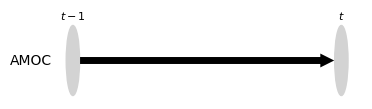

In [113]:
# assuming lag 1 influence of AMOC on AMOC
graph =  np.array([[['', '-->']],], dtype='<U3')

X = [(0,-1)]
Y = [(0,0)]

causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)
tp.plot_time_series_graph(graph, var_names=['AMOC'], node_size=0.2, arrow_linewidth=5, figsize=(4, 1))

In [68]:
# largest_slopes, fig = plowindow_length_analysis(causal_effects, AMOC_Caesar_det.values.reshape(-1, 1), var_names=[r'$AMOC$'], time_windows=time_windows, rows=13, cols=6, 
#                                            n_points=n_points, estimator=KNeighborsRegressor(), data_transform=StandardScaler(), edge_points_proportion=0.15)

In [69]:
# causal_KNN_AMOC, _, _ = ind.pipeline_causalEE_weighted(
#     causal_effects, AMOC_Caesar_det.values.reshape(-1, 1), KNeighborsRegressor(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$AMOC$'], edge_points_proportion=0.15)
# causal_LinReg_AMOC, _, _ = ind.pipeline_causalEE_weighted(
#     causal_effects, AMOC_Caesar_det.values.reshape(-1, 1), LinearRegression(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$AMOC$'], edge_points_proportion=0.15)

In [ ]:
#causal_KNN_AMOC, _, _, bootstrap_KNN_AMOC, CI_KNN_AMOC = pipeline_causalEE_weighted_bootstrap(
#    causal_effects, AMOC_Caesar_det.reshape(-1, 1), KNeighborsRegressor(), n_bootstrap=n_bootstrap, boot_blocklength=1, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$AMOC$'], edge_points_proportion=0.15, CI=90)
causal_LinReg_Caesar_1871_2013, _, _, bootstrap_LinReg_Caesar_1871_2013, CI_LinReg_Caesar_1871_2013 = pipeline_causalEE_weighted_bootstrap(
    causal_effects, AMOC_Caesar_det.reshape(-1, 1), LinearRegression(), n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$AMOC$'], edge_points_proportion=0.15, CI=90, detrend=True)

# AMOC (Caesar) and CWG

In [ ]:
t_len = len(years_1958_2016)

window_length = 30
window_step = 1

time_windows, center_points = sw.get_centered_sliding_windows(window_length, window_step, t_len)

In [122]:
helpers.plot_smoothing(total_freshwater, total_freshwater-FWF_1958_2016_det, FWF_1958_2016_det)

In [70]:
helpers.plot_r_ac1(CWG_log, residuals=CWG_log_det, trend=CWG_log-CWG_log_det, window_size=window_length)

In [71]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("AMOC vs CWG", "AMOC vs log CWG"), horizontal_spacing=0.15)

fig.add_trace(go.Scatter(x=CWG_det, y=AMOC_Caesar_det, mode='markers', marker=dict(color='#00CCFF')),row=1, col=1)
fig.add_trace(go.Scatter(x=CWG_log_det, y=AMOC_Caesar_det, mode='markers', marker=dict(color='#00CCFF')),row=1, col=2)

fig.update_layout(plot_bgcolor='rgba(215, 238, 244, 0.3)', width=800, height=400, showlegend=False,)
fig.update_xaxes(title_text="CWG", row=1, col=1)
fig.update_yaxes(title_text="AMOC", row=1, col=1)
fig.update_xaxes(title_text="log CWG", row=1, col=2)

fig.show()

## AC and RRate

In [66]:
def block_bootstrap_sliding_windows(
    time_series,
    time_windows,
    boot_blocklength,
    n_bootstrap,
    seed=0
):
    """
    Block bootstrap sur des fenêtres glissantes d'une série temporelle univariée,
    avec recentrage de chaque réplique bootstrap pour conserver la moyenne locale.

    Parameters
    ----------
    time_series : np.ndarray
        Tableau 1D de forme (T,) représentant la série temporelle.
    time_windows : list of np.ndarray
        Liste de tableaux d’indices, chaque tableau spécifie les indices temporels d’une fenêtre.
    boot_blocklength : int
        Longueur des blocs bootstrap.
    n_bootstrap : int
        Nombre de réplicats bootstrap par fenêtre.
    seed : int, optional
        Graine aléatoire pour la reproductibilité.

    Returns
    -------
    np.ndarray
        Réplicats bootstrap de forme (n_bootstrap, n_windows, window_length).
    """
    seed_seq = np.random.SeedSequence(seed)
    window_seeds = seed_seq.spawn(len(time_windows))

    n_windows = len(time_windows)
    window_length = len(time_windows[0])
    output = np.empty((n_bootstrap, n_windows, window_length))

    for w_idx, (window_indices, window_seed) in enumerate(zip(time_windows, window_seeds)):
        rng = np.random.default_rng(window_seed)
        window_data = time_series[window_indices]
        n_blocks = int(np.ceil(window_length / boot_blocklength))

        for b in range(n_bootstrap):
            block_starts = rng.integers(0, window_length - boot_blocklength + 1, size=n_blocks)
            bootstrapped = np.concatenate([
                window_data[start:start + boot_blocklength]
                for start in block_starts
            ])[:window_length]

            output[b, w_idx] = bootstrapped

    return output

In [67]:
def regular_autocorrelation(data, time_windows, n_bootstrap=100, boot_blocklength=10, CI=90, lag=1, detrend=True):
    """
    Computes autocorrelation (e.g. AC1) on sliding windows of a time series,
    with optional bootstrap confidence intervals.

    Parameters
    ----------
    data : np.ndarray
        Univariate time series of shape (T,)
    time_windows : list of np.ndarray
        List of index arrays specifying the time windows.
    lag : int
        Lag at which to compute autocorrelation.
    n_bootstrap : int
        Number of bootstrap samples. If 0, only original autocorrelation is returned.
    boot_blocklength : int
        Block length for block bootstrap.
    CI : int
        Confidence interval level (e.g. 90 or 95).
    detrend : bool
        If True, remove linear trend before computing autocorrelation.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    orig_autocorr : np.ndarray
        Autocorrelation values on the original data per window.
    bootstrap_autocorr : np.ndarray or None
        Bootstrap autocorrelations per window, shape (n_bootstrap, n_windows), or None if n_bootstrap=0.
    confidence_interval : np.ndarray or None
        Percentile CI of bootstrap samples (2, n_windows), or None if n_bootstrap=0.
    """
    assert data.ndim == 1, "Only univariate time series are supported."

    # Compute original autocorrelation on each window
    orig_autocorr = []
    for window in time_windows:
        if window[-1] >= len(data):
            break
        xw = data[window]

        if detrend:
            xw = xw - xw.mean()
            p0, p1 = np.polyfit(np.arange(len(xw)), xw, 1)
            xw = xw - (p0 * np.arange(len(xw)) + p1)
        series = pd.Series(xw)
        orig_autocorr.append(series.autocorr(lag))
    
    orig_autocorr = np.array(orig_autocorr)

    if n_bootstrap == 0:
        return orig_autocorr

    # Generate bootstrap samples
    boot_data = block_bootstrap_sliding_windows(
        time_series=data,
        time_windows=time_windows,
        boot_blocklength=boot_blocklength,
        n_bootstrap=n_bootstrap,
    )  # shape: (n_bootstrap, n_windows, window_length)

    # Compute bootstrap autocorrelations
    n_windows = len(orig_autocorr)
    bootstrap_autocorr = np.empty((n_bootstrap, n_windows))

    for i in range(n_bootstrap):
        for w in range(n_windows):
            xw = boot_data[i, w]
            if detrend:
                xw = xw - xw.mean()
                p0, p1 = np.polyfit(np.arange(len(xw)), xw, 1)
                xw = xw - (p0 * np.arange(len(xw)) + p1)
            series = pd.Series(xw)
            bootstrap_autocorr[i, w] = series.autocorr(lag)

    # Compute confidence intervals
    if CI == 90:
        confidence_interval = np.percentile(bootstrap_autocorr, [5, 95], axis=0)
    elif CI == 95:
        confidence_interval = np.percentile(bootstrap_autocorr, [2.5, 97.5], axis=0)
    else:
        raise ValueError("CI must be either 90 or 95")

    return orig_autocorr, bootstrap_autocorr, confidence_interval


In [68]:
import statsmodels.api as sm
def restoring_rate(data, time_windows, rho=1, n_bootstrap=100, boot_blocklength=10, CI=90, detrend=True):
    """
    Computes restoring rate (AR(1) coefficient on dx = a*x + eps) on sliding windows,
    with optional bootstrap confidence intervals.

    Parameters
    ----------
    data : np.ndarray
        Univariate time series of shape (T,)
    time_windows : list of np.ndarray
        List of index arrays specifying the time windows.
    rho : int
        Lag parameter for GLSAR.
    n_bootstrap : int
        Number of bootstrap samples. If 0, only original restoring rates are returned.
    boot_blocklength : int
        Block length for block bootstrap.
    CI : int
        Confidence interval level (e.g. 90 or 95).
    detrend : bool
        If True, remove linear trend before estimating restoring rate.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    orig_restoring : np.ndarray
        Restoring rate values (AR(1) coefficient) on original data per window.
    bootstrap_restoring : np.ndarray or None
        Bootstrap restoring rates per window, shape (n_bootstrap, n_windows), or None if n_bootstrap=0.
    confidence_interval : np.ndarray or None
        Percentile CI of bootstrap samples (2, n_windows), or None if n_bootstrap=0.
    """
    assert data.ndim == 1, "Only univariate time series are supported."

    orig_restoring = []
    for window in time_windows:
        if window[-1] >= len(data):
            break
        xw = data[window]

        # Mean subtraction
        xw = xw - xw.mean()

        if detrend:
            p0, p1 = np.polyfit(np.arange(len(xw)), xw, 1)
            xw = xw - (p0 * np.arange(len(xw)) + p1)

        dxw = np.diff(xw)
        xw_const = sm.add_constant(xw[:-1])
        model = sm.GLSAR(dxw, xw_const, rho=rho)
        results = model.iterative_fit(maxiter=1000)

        if not results.converged:
            print("Warning: AR(1) model did not converge.")
            orig_restoring.append(np.nan)
        else:
            orig_restoring.append(results.params[1])

    orig_restoring = np.array(orig_restoring)

    if n_bootstrap == 0:
        return orig_restoring

    # Generate bootstrap samples
    boot_data = block_bootstrap_sliding_windows(
        time_series=data,
        time_windows=time_windows,
        boot_blocklength=boot_blocklength,
        n_bootstrap=n_bootstrap,
    )  # shape: (n_bootstrap, n_windows, window_length)

    # Compute bootstrap restoring rates
    n_windows = len(orig_restoring)
    bootstrap_restoring = np.empty((n_bootstrap, n_windows))

    for i in range(n_bootstrap):
        for w in range(n_windows):
            xw = boot_data[i, w]
            xw = xw - xw.mean()

            if detrend:
                p0, p1 = np.polyfit(np.arange(len(xw)), xw, 1)
                xw = xw - (p0 * np.arange(len(xw)) + p1)

            dxw = np.diff(xw)
            xw_const = sm.add_constant(xw[:-1])
            model = sm.GLSAR(dxw, xw_const, rho=rho)
            results = model.iterative_fit(maxiter=1000)

            if not results.converged:
                bootstrap_restoring[i, w] = np.nan
            else:
                bootstrap_restoring[i, w] = results.params[1]

    # Compute confidence intervals
    if CI == 90:
        confidence_interval = np.nanpercentile(bootstrap_restoring, [5, 95], axis=0)
    elif CI == 95:
        confidence_interval = np.nanpercentile(bootstrap_restoring, [2.5, 97.5], axis=0)
    else:
        raise ValueError("CI must be either 90 or 95")

    return orig_restoring, bootstrap_restoring, confidence_interval


In [69]:
def restoring_rate_logtransformed(data, time_windows, rho=1, n_bootstrap=100,
                                   boot_blocklength=10, CI=90, detrend=True, seed=0):
    """
    Computes log-transformed restoring rate: lambda = -log(1 + a),
    where a is the AR(1) coefficient from Δx_t = a * x_{t-1} + ε_t.

    Parameters
    ----------
    data : np.ndarray
        Univariate time series of shape (T,)
    time_windows : list of np.ndarray
        List of index arrays specifying the time windows.
    rho : int
        Lag parameter for GLSAR.
    n_bootstrap : int
        Number of bootstrap samples. If 0, only original restoring rates are returned.
    boot_blocklength : int
        Block length for block bootstrap.
    CI : int
        Confidence interval level (e.g. 90 or 95).
    detrend : bool
        If True, remove linear trend before estimating restoring rate.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    orig_lambda : np.ndarray
        Log-transformed restoring rate per window: -log(1 + a)
    bootstrap_lambda : np.ndarray or None
        Bootstrap estimates, shape (n_bootstrap, n_windows), or None.
    confidence_interval : np.ndarray or None
        Confidence intervals of bootstrap samples, shape (2, n_windows), or None.
    """

    def safe_log_transform(a):
        with np.errstate(divide='ignore', invalid='ignore'):
            return -np.log1p(a)  # log1p(a) = log(1 + a), safe for small a

    assert data.ndim == 1, "Only univariate time series are supported."

    orig_lambda = []
    for window in time_windows:
        if window[-1] >= len(data):
            break
        xw = data[window]
        xw = xw - xw.mean()

        if detrend:
            p0, p1 = np.polyfit(np.arange(len(xw)), xw, 1)
            xw = xw - (p0 * np.arange(len(xw)) + p1)

        dxw = np.diff(xw)
        xw_const = sm.add_constant(xw[:-1])
        model = sm.GLSAR(dxw, xw_const, rho=rho)
        results = model.iterative_fit(maxiter=1000)

        if not results.converged:
            orig_lambda.append(np.nan)
        else:
            a = results.params[1]
            orig_lambda.append(safe_log_transform(a))

    orig_lambda = np.array(orig_lambda)

    if n_bootstrap == 0:
        return orig_lambda, None, None

    from numpy.random import default_rng
    from copy import deepcopy
    rng = default_rng(seed)

    # Generate bootstrap samples
    boot_data = block_bootstrap_sliding_windows(
        time_series=data,
        time_windows=time_windows,
        boot_blocklength=boot_blocklength,
        n_bootstrap=n_bootstrap,
        seed=seed
    )

    n_windows = len(orig_lambda)
    bootstrap_lambda = np.empty((n_bootstrap, n_windows))

    for i in range(n_bootstrap):
        for w in range(n_windows):
            xw = boot_data[i, w]
            xw = xw - xw.mean()

            if detrend:
                p0, p1 = np.polyfit(np.arange(len(xw)), xw, 1)
                xw = xw - (p0 * np.arange(len(xw)) + p1)

            dxw = np.diff(xw)
            xw_const = sm.add_constant(xw[:-1])
            model = sm.GLSAR(dxw, xw_const, rho=rho)
            results = model.iterative_fit(maxiter=1000)

            if not results.converged:
                bootstrap_lambda[i, w] = np.nan
            else:
                a = results.params[1]
                bootstrap_lambda[i, w] = safe_log_transform(a)

    if CI == 90:
        confidence_interval = np.nanpercentile(bootstrap_lambda, [5, 95], axis=0)
    elif CI == 95:
        confidence_interval = np.nanpercentile(bootstrap_lambda, [2.5, 97.5], axis=0)
    else:
        raise ValueError("CI must be either 90 or 95")

    return orig_lambda, bootstrap_lambda, confidence_interval


In [70]:
n_bootstrap = 100
boot_blocklength = 4
n_points = 150
edge_points_proportion = 0.05

In [79]:
AC_AMOC, bootstrap_AC_AMOC, CI_AC_AMOC = regular_autocorrelation(data=AMOC_Caesar_det, time_windows=time_windows, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, 
                                                                 lag=1, detrend=True)

In [80]:
AC_median_boot = np.nanmedian(bootstrap_AC_AMOC, axis=0)
x = np.arange(len(AC_median_boot)) 
slope_AC_median_boot, intercept_AC_median_boot = np.polyfit(x, AC_median_boot, 1)

slope_AC, intercept_AC = np.polyfit(x, AC_AMOC, 1)

print('original slope: ', slope_AC, 'bootstrap slope: ', slope_AC_median_boot)

original slope:  0.002517706073487893 bootstrap slope:  0.002837065007783182


In [81]:
rrate_AMOC, bootstrap_rrate_AMOC, CI_rrate_AMOC = restoring_rate(data=AMOC_Caesar_det, time_windows=time_windows, rho=1, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, 
                                                                 detrend=True)

In [82]:
rrate_median_boot = np.nanmedian(bootstrap_rrate_AMOC, axis=0)
x = np.arange(len(rrate_median_boot)) 
slope_rrate_median_boot, intercept_rrate_median_boot = np.polyfit(x, rrate_median_boot, 1)

slope_rrate, intercept_rrate = np.polyfit(x, rrate_AMOC, 1)

print('original slope: ', slope_rrate, 'bootstrap slope: ', slope_rrate_median_boot)

original slope:  0.009377097543869594 bootstrap slope:  0.006034538651297852


In [83]:
# plot_AC_rrate_with_confidence_box(AC_AMOC=AC_AMOC, bootstrap_AC_AMOC=bootstrap_AC_AMOC,
#                                   rrate_AMOC=rrate_AMOC, bootstrap_rrate_AMOC=bootstrap_rrate_AMOC,
#                                   nb_surrogates=10)

In [84]:
#AC_AMOC = ind.regular_autocorrelation(AMOC_Caesar_det.values, time_windows, lag=1, detrend=True)
#rrate_AMOC = ind.restoring_rate(AMOC_Caesar_det.values, time_windows, rho=1, detrend=True)
bb_AMOC, _, _ = ind.BB_method(AMOC_Caesar_det, window_length)

In [85]:
#AC_CWG_log = ind.regular_autocorrelation(CWG_log_det.values, time_windows, lag=1, detrend=True)
AC_CWG_log, bootstrap_AC_CWG_log, CI_AC_CWG_log = regular_autocorrelation(data=CWG_log_det, time_windows=time_windows, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, 
                                                                 lag=1, detrend=True)
rrate_CWG_log = ind.restoring_rate(CWG_log_det, time_windows, rho=1, detrend=True)
bb_CWG_log, _, _ = ind.BB_method(CWG_log_det, window_length)

## GIS only (CWG)

In [86]:
data_log_CWG = np.hstack([df_1871_2013[['JJA']].values, CWG_log_det.reshape(-1, 1), AMOC_Caesar_det.reshape(-1, 1)])

In [87]:
lags = range(1, 11)
pacf_vals_CWG = pacf(CWG_log_det, nlags=10)[1:]
pacf_vals_NU = pacf(NU_log_det, nlags=10)[1:]

fig = make_subplots(rows=1, cols=2, subplot_titles=("CWG (log)", "NU (log)"), shared_yaxes=True)
fig.add_trace(
    go.Scatter(x=list(lags), y=pacf_vals_CWG, mode='markers', marker=dict(size=10, color='rgb(115,175,72)'), name="CWG"),
        row=1, col=1)
fig.add_trace(
    go.Scatter(x=list(lags), y=pacf_vals_NU, mode='markers', marker=dict(size=10, color='rgb(115,175,72)'), name="NU"),
    row=1, col=2)

fig.update_layout(height=400, width=1000,template="plotly_white",showlegend=False,)
fig.update_xaxes(title_text="Lag", tickvals=list(lags), row=1, col=1)
fig.update_xaxes(title_text="Lag", tickvals=list(lags), row=1, col=2)
fig.update_yaxes(title_text="Partial Autocorrelation", row=1, col=1)
fig.show()


In [ ]:
# assuming lag 1 influence of GIS on GIS
graph =  np.array([[['', '-->']],], dtype='<U3')

X = [(0,-1)]
Y = [(0,0)]

causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)

6

In [89]:
# largest_slopes, fig = plowindow_length_analysis(causal_effects, data_log_CWG[:, 1].reshape(-1, 1), var_names=[r'CWG_log'], time_windows=time_windows, rows=13, cols=6, 
#                                            n_points=n_points, estimator=KNeighborsRegressor(), data_transform=StandardScaler(), edge_points_proportion=0.15)

In [ ]:
#causal_KNN_CWG, _, _, bootstrap_KNN_CWG, CI_KNN_CWG = pipeline_causalEE_weighted_bootstrap(
#    causal_effects, data_log_CWG[:, 1].reshape(-1,1), KNeighborsRegressor(), n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$CWG_log$'], edge_points_proportion=0.15, CI=90)
causal_LinReg_CWG, _, _, bootstrap_LinReg_CWG, CI_LinReg_CWG = pipeline_causalEE_weighted_bootstrap(
    causal_effects, data_log_CWG[:, 1].reshape(-1,1), LinearRegression(), n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$CWG_log$'], edge_points_proportion=0.05, CI=90, detrend=True)

## Causal effect of GrIS CWG on AMOC

In [91]:
lags = range(-10, 11)
cross_correlations = []
Ns = []

for lag in lags:
    if lag < 0:
        x = CWG_log_det[-lag:]
        y = AMOC_Caesar_det[:lag]
    elif lag > 0:
        x = CWG_log_det[:-lag]
        y = AMOC_Caesar_det[lag:]
    else:
        x = CWG_log_det
        y = AMOC_Caesar_det

    if len(x) == len(y) and len(x) > 1:
        corr = np.corrcoef(x, y)[0, 1]
        N = len(x)
    else:
        corr = None
        N = None

    cross_correlations.append(corr)
    Ns.append(N)

# Confidence intervals : ±1.96 / sqrt(N)
conf95 = [1.96 / np.sqrt(n) if n is not None else None for n in Ns]

df = pd.DataFrame({
    "Lag": lags,
    "Cross-Correlation": cross_correlations,
    "Upper": [r + c if r is not None and c is not None else None for r, c in zip(cross_correlations, conf95)],
    "Lower": [r - c if r is not None and c is not None else None for r, c in zip(cross_correlations, conf95)],
})

fig = px.scatter(
    df, x="Lag", y="Cross-Correlation",
    title="Cross-Correlations between AMOC (Caesar) and GrIS (log CWG)",
    labels={"Lag": "Lag", "Cross-Correlation": "Cross-Correlation"},
    template="plotly_white"
)

fig.update_traces(marker=dict(size=10, color='purple'))

fig.add_traces([
    dict(type='scatter', x=df["Lag"], y=df["Upper"], mode='lines', line=dict(color='gray', dash='dash'), showlegend=False),
    dict(type='scatter', x=df["Lag"], y=df["Lower"], mode='lines', line=dict(color='gray', dash='dash'), showlegend=False)
])

fig.update_layout(width=800, height=500)
fig.show()

In [92]:
graphsCE = [
    np.array([[['', '-->'], ['-->', '']],
            [['<--', ''], ['', '-->']],], dtype='<U3'), 

    np.array([[['', '-->'], ['', '-->']],
    [['', ''], ['', '-->']],], dtype='<U3'),

    np.array([[['', '-->', ''], ['', '', '-->']],
    [['', '', ''], ['', '-->', '']],], dtype='<U3'),

    np.array([[['', '-->', '', ''], ['', '', '', '-->']],
    [['', '', '', ''], ['', '-->', '', '']]], dtype='<U3'),

    np.array([[['', '-->', '', '', ''], ['', '', '', '', '-->']],
                [['', '', '', '', ''], ['', '-->', '', '', '']]], dtype='<U3'),

    np.array([[['', '-->', '', '', '', ''], ['', '', '', '', '', '-->']],
                [['', '', '', '', '', ''], ['', '-->', '', '', '', '']]], dtype='<U3'), 
    ]

In [93]:
# for graph in graphsCE:
#     tp.plot_time_series_graph(graph, var_names=[r'GrIS', r'AMOC'], figsize=(3,2))

In [94]:
intervention_data, intervention_data_here = ind.produce_intervention_data(data_log_CWG[:, 1], 0.01, 100)
dataframe = pp.DataFrame(data_log_CWG[:, 1:], var_names = ['CWG_log', 'AMOC_Caesar'])

list_causal_KNN_GIS_on_AMOC_intervention_data = []
for i in range(len(graphsCE)):
    graph = graphsCE[i]
    X = [(0,-i)] # GIS
    Y = [(1,0)] # AMOC

    causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)
    
    causal_effects.fit_total_effect(dataframe=dataframe, estimator=KNeighborsRegressor(), adjustment_set='optimal', conditional_estimator=None, data_transform=StandardScaler(), mask_type=None,)
    estimated_causal_effects_KNN = causal_effects.predict_total_effect(intervention_data=intervention_data_here, transform_interventions_and_prediction=True,)
    #slopeKNN, interceptKNN = np.polyfit(intervention_data, estimated_causal_effects_KNN, 1)

    list_causal_KNN_GIS_on_AMOC_intervention_data.append(estimated_causal_effects_KNN)

In [96]:
fig = go.Figure()

for i, causal_KNN_GIS_AMOC in enumerate(list_causal_KNN_GIS_on_AMOC_intervention_data):
    fig.add_trace(go.Scatter(
        x=intervention_data, y=causal_KNN_GIS_AMOC, mode='lines',
        name=f'Lag {i}',
        line=dict(color=f'rgb({i*40}, {100 + i*30}, {200 - i*20})')
    ))

fig.update_layout(
    title='Causal Effect of GrIS on AMOC at different lags',
    xaxis=dict(title='Intervention data'), yaxis=dict(title='Causal Effect'),
    width=800, height=500, template='plotly_white'
)
fig.show()

In [ ]:
list_causal_KNN_GIS_on_AMOC_time = []
for i in range(len(graphsCE)):
    graph = graphsCE[i]
    X = [(0,-i)] # GIS
    Y = [(1,0)] # AMOC

    causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)
    causal_effect_GIS_AMOC, _, _ = ind.pipeline_causalEE_weighted(
    causal_effects, data_log_CWG[:, 1:], KNeighborsRegressor(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$CWG_log$', r'$AMOC$'], edge_points_proportion=0.15, detrend=True)

    list_causal_KNN_GIS_on_AMOC_time.append(causal_effect_GIS_AMOC)

In [98]:
start_index = window_length // 2
end_index = len(years_1871_2013) - (window_length // 2)
x = years_1871_2013[start_index:end_index]

fig = go.Figure()

for i, causal_KNN_GIS_AMOC in enumerate(list_causal_KNN_GIS_on_AMOC_time):
    fig.add_trace(go.Scatter(
        x=x, y=causal_KNN_GIS_AMOC, mode='lines',
        name=f'Lag {i}',
        line=dict(color=f'rgb({i*40}, {100 + i*30}, {200 - i*20})')
    ))

fig.update_layout(
    title='Evolution of the Causal Effect of GrIS on AMOC at different lags',
    xaxis=dict(title='Year'), yaxis=dict(title='Causal Effect'),
    width=800, height=600, template='plotly_white'
)
fig.show()

### Which graph is the most plausible given the data?

In [99]:
GrIS_parents = [(0, -1)]
AMOC_parents_0 = [(1, -1), (0, 0)]
AMOC_parents_1 = [(1, -1), (0, -1)]
AMOC_parents_2 = [(1, -1), (0, -2)]
AMOC_parents_3 = [(1, -1), (0, -3)]
AMOC_parents_4 = [(1, -1), (0, -4)]
AMOC_parents_5 = [(1, -1), (0, -5)]
AMOC_parents_6 = [(1, -1), (0, -6)]
AMOC_parents_7 = [(1, -1), (0, -7)]
AMOC_parents_8 = [(1, -1), (0, -8)]
AMOC_parents_9 = [(1, -1), (0, -9)]
AMOC_parents_10 = [(1, -1), (0, -10)]

In [100]:
dataframe = pp.DataFrame(data_log_CWG[:, 1:], var_names = ['CWG_log', 'AMOC_Caesar'])

In [101]:
model = CMIknn(knn=5, transform=None)

In [102]:
model.dataframe = dataframe

In [103]:
tau_max = 10

In [104]:
score_GrIS = model.get_model_selection_criterion(j=0, parents = GrIS_parents, tau_max=tau_max)
score_AMOC_0 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_0, tau_max=tau_max)
score_AMOC_1 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_1, tau_max=tau_max)
score_AMOC_2 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_2, tau_max=tau_max)
score_AMOC_3 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_3, tau_max=tau_max)
score_AMOC_4 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_4, tau_max=tau_max)
score_AMOC_5 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_5, tau_max=tau_max)
score_AMOC_6 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_6, tau_max=tau_max)
score_AMOC_7 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_7, tau_max=tau_max)
score_AMOC_8 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_8, tau_max=tau_max)
score_AMOC_9 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_9, tau_max=tau_max)
score_AMOC_10 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_10, tau_max=tau_max)

In [105]:
score_graphs = [
    (score_GrIS+score_AMOC_0)/2,
    (score_GrIS+score_AMOC_1)/2,
    (score_GrIS+score_AMOC_2)/2,
    (score_GrIS+score_AMOC_3)/2,
    (score_GrIS+score_AMOC_4)/2,
    (score_GrIS+score_AMOC_5)/2,
    (score_GrIS+score_AMOC_6)/2,
    (score_GrIS+score_AMOC_7)/2,
    (score_GrIS+score_AMOC_8)/2,
    (score_GrIS+score_AMOC_9)/2,
    (score_GrIS+score_AMOC_10)/2,]

In [106]:
graph_scores = [(i, round(score, 3)) for i, score in enumerate(score_graphs)]
sorted_graph_scores = sorted(graph_scores, key=lambda x: x[1])

df_scores = pd.DataFrame(sorted_graph_scores, columns=['Graph #', 'Score'])
print(df_scores)

    Graph #  Score
0         2  0.011
1         8  0.035
2         4  0.043
3         3  0.064
4         9  0.066
5         6  0.095
6         1  0.097
7         5  0.100
8         0  0.101
9        10  0.110
10        7  0.129


In [107]:
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=model,
    verbosity=0
)

/opt/anaconda3/envs/tigramite_env/lib/python3.10/site-packages/tigramite/plotting.py:3397: RuntimeWarning:

invalid value encountered in double_scalars



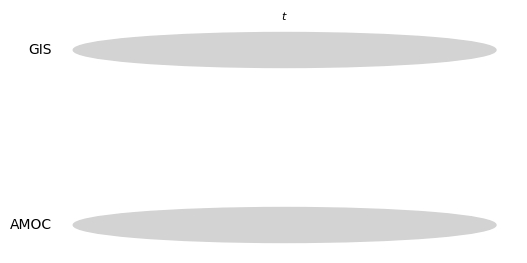

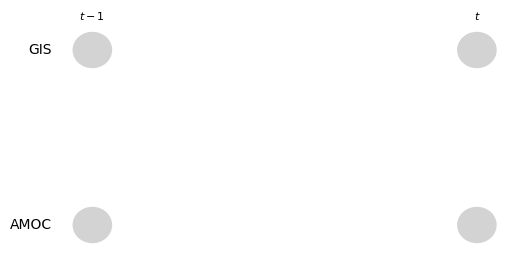

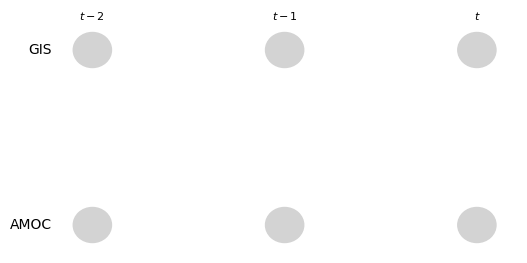

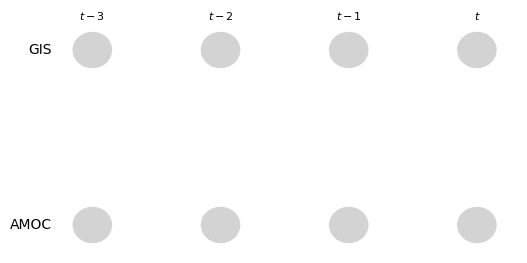

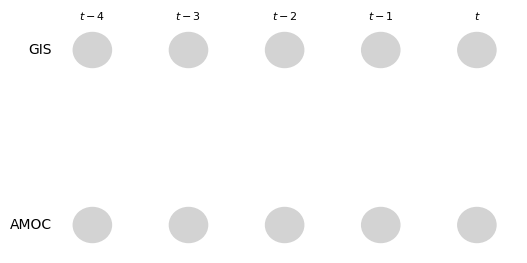

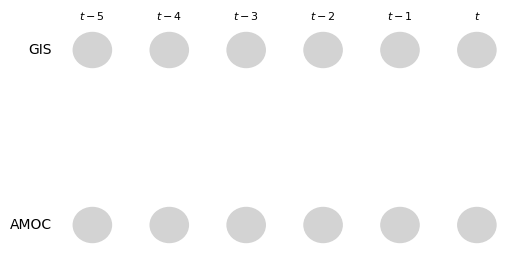

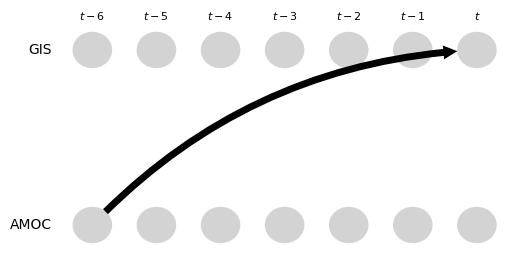

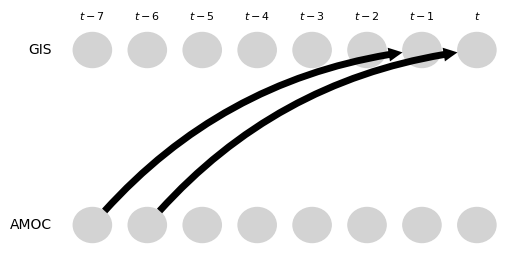

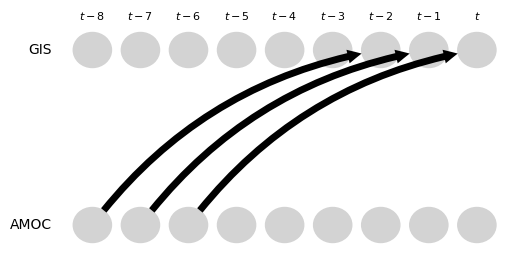

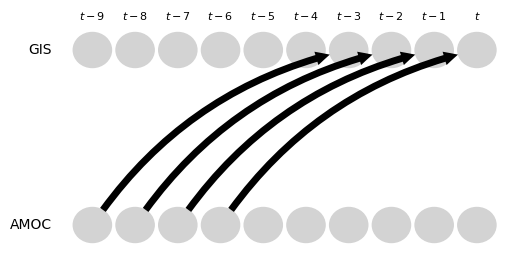

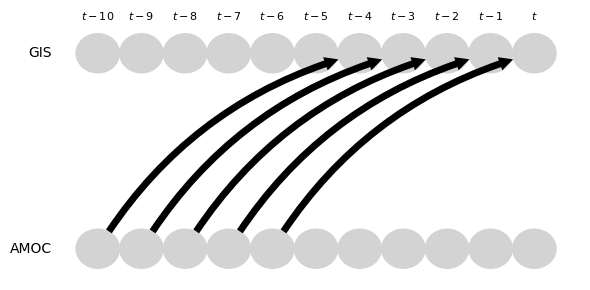

In [ ]:
# Paramètres de base
lag_range = range(0, 11)  # tau_max de 0 à 10
var_names = ['GIS', 'AMOC']  # à adapter
N = len(var_names)
alpha = 0.10  # niveau de signification pour le test d'hypothèse

# Préparation de la figure
ncols = 4
nrows = int(np.ceil(len(lag_range) / ncols))

for idx, tau_max in enumerate(lag_range):
    result = pcmci.get_lagged_dependencies(
        tau_min=0,
        tau_max=tau_max,
        val_only=False,
        alpha_level=alpha,
        fdr_method='fdr_bh'
    )
    p_matrix = result['p_matrix']
    graph = result['graph']

    plot_graph(
        graph=graph,
        var_names=var_names,
        node_size=0.2,
        arrow_linewidth=5,
        figsize=(6, 3),  # still required even if ax is implicitly used
    )
    #ax.set_title(f"tau_max = {tau_max}", fontsize=12)

plt.tight_layout()
plt.show()

In [92]:
# lag_range = range(0, 11)  # tau_max from 0 to 5
# val_matrices = []
# mean_scores = []

# for tau_max in lag_range:
#     # Run lagged dependency test
#     result = pcmci.get_lagged_dependencies(
#         tau_min=0,
#         tau_max=tau_max,
#         val_only=False,
#         alpha_level=0.05,
#         fdr_method='fdr_bh'
#     )
#     graph = result['graph']
#     val_matrix = result['val_matrix']
#     p_matrix = result['p_matrix']
    
#     # Store the full val_matrix for further inspection if needed
#     val_matrices.append(val_matrix)
#     # Compute a global score: mean absolute dependence over all variables and lags
#     mean_val = abs(val_matrix).mean()
#     mean_scores.append(round(mean_val, 3))

# # Create DataFrame with results
# df_lag_comparison = pd.DataFrame({
#     "tau_max": list(lag_range),
#     "score": mean_scores
# })

# # Sort by score ascending (lower is better fit)
# df_lag_comparison = df_lag_comparison.sort_values(by="score", ascending=False).reset_index(drop=True)
# print(df_lag_comparison)


In [93]:
idx_GrIS = 0
idx_AMOC = 1

results = []

for tau_max in lag_range:
    result = pcmci.get_lagged_dependencies(
        tau_min=0,
        tau_max=tau_max,
        val_only=False,
        alpha_level=0.05,
        fdr_method='fdr_bh'
    )
    val_matrix = result['val_matrix']
    
    # Extract relevant slices (lags from 0 to tau_max)
    # val_matrix shape : (n_vars, n_vars, tau_max+1)
    
    # GrIS → GrIS
    vals_GrIS_GrIS = val_matrix[idx_GrIS, idx_GrIS, :tau_max+1]
    lag_max_GrIS_GrIS = np.abs(vals_GrIS_GrIS).argmax()
    val_max_GrIS_GrIS = vals_GrIS_GrIS[lag_max_GrIS_GrIS]
    
    # AMOC → AMOC
    vals_AMOC_AMOC = val_matrix[idx_AMOC, idx_AMOC, :tau_max+1]
    lag_max_AMOC_AMOC = np.abs(vals_AMOC_AMOC).argmax()
    val_max_AMOC_AMOC = vals_AMOC_AMOC[lag_max_AMOC_AMOC]
    
    # GrIS → AMOC
    vals_GrIS_AMOC = val_matrix[idx_AMOC, idx_GrIS, :tau_max+1]
    lag_max_GrIS_AMOC = np.abs(vals_GrIS_AMOC).argmax()
    val_max_GrIS_AMOC = vals_GrIS_AMOC[lag_max_GrIS_AMOC]
    
    results.append({
        "tau_max": tau_max,
        "lag_max_GrIS_GrIS": lag_max_GrIS_GrIS,
        "val_max_GrIS_GrIS": val_max_GrIS_GrIS,
        "lag_max_AMOC_AMOC": lag_max_AMOC_AMOC,
        "val_max_AMOC_AMOC": val_max_AMOC_AMOC,
        "lag_max_GrIS_AMOC": lag_max_GrIS_AMOC,
        "val_max_GrIS_AMOC": val_max_GrIS_AMOC
    })

df_results = pd.DataFrame(results)
print(df_results)


    tau_max  lag_max_GrIS_GrIS  val_max_GrIS_GrIS  lag_max_AMOC_AMOC  \
0         0                  0           0.000000                  0   
1         1                  1           0.060265                  1   
2         2                  2           0.075972                  1   
3         3                  2           0.085391                  1   
4         4                  2           0.088493                  1   
5         5                  2           0.089320                  1   
6         6                  2           0.078499                  1   
7         7                  2           0.083781                  1   
8         8                  2           0.080591                  1   
9         9                  1           0.075861                  1   
10       10                  1           0.079194                  1   

    val_max_AMOC_AMOC  lag_max_GrIS_AMOC  val_max_GrIS_AMOC  
0            0.000000                  0           0.011713  
1          

## CSD analysis

In [70]:
n_bootstrap = 100
boot_blocklength=4
nb_surrogates = 10000

In [71]:
t_len = len(years_1871_2013)

window_length = 70
window_step = 1

time_windows, center_points = sw.get_centered_sliding_windows(window_length, window_step, t_len)

In [72]:
n_points = 150

### AMOC only

In [70]:
# assuming lag 1 influence of AMOC on AMOC
graph =  np.array([[['', '-->']],], dtype='<U3')

X = [(0,-1)]
Y = [(0,0)]

causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)

In [ ]:
#causal_KNN_AMOC, _, _, bootstrap_KNN_AMOC, CI_KNN_AMOC = pipeline_causalEE_weighted_bootstrap(
#    causal_effects, AMOC_Caesar_det.reshape(-1, 1), KNeighborsRegressor(), n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$AMOC$'], edge_points_proportion=0.15, CI=90)
causal_LinReg_AMOC, _, _, bootstrap_LinReg_AMOC, CI_LinReg_AMOC = pipeline_causalEE_weighted_bootstrap(
    causal_effects, AMOC_Caesar_det.reshape(-1, 1), LinearRegression(), n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$AMOC$'], edge_points_proportion=0.15, CI=90, detrend=True)

## Different lags between GIS and AMOC

In [71]:
def compute_and_save_plot_data(graphs, nb_surrogates, save_path='boxplot.pkl'):
    def compute_slopes_and_pvalues(bootstrap_series_list):
        slopes, pvals = [], []
        for series in bootstrap_series_list:
            slope, _ = np.polyfit(np.arange(len(series)), series, 1)
            pval, _ = sgtest.p_value_from_fourier(series, nb_surrogates, slope, seed=0)
            pvals.append(float(np.array(pval).flatten()[0]))
            slopes.append(slope)
        return slopes, pvals

    def extract_pval(value):
        slope, _ = np.polyfit(np.arange(len(value)), value, 1)
        pval, _ = sgtest.p_value_from_fourier(value, nb_surrogates, slope, seed=0)
        return slope, float(np.array(pval).flatten()[0])

    processed_graphs = []

    for i, graph in enumerate(graphs):
        slopes, pvals = compute_slopes_and_pvalues(graph['bootstrap_values'])
        central_slope, central_pval = extract_pval(graph['values'])

        processed_graph = {
            'label': graph['label'],
            'central_slope': central_slope,
            'central_pval': central_pval,
            'bootstrap_slopes': slopes,
            'bootstrap_pvals': pvals,
            'color': graph.get('color', f"rgb({i*40%255},{i*60%255},{i*80%255})")
        }
        processed_graphs.append(processed_graph)

    with open(save_path, 'wb') as f:
        pickle.dump(processed_graphs, f)

In [123]:
def plot_precomputed_results_boxplot(processed_graphs):

    fig = go.Figure()

    central_vals = [g['central_slope'] for g in processed_graphs]
    central_pvals = [g['central_pval'] for g in processed_graphs]
    x_labels = [g['label'] for g in processed_graphs]
    all_bootstrap_slopes = [g['bootstrap_slopes'] for g in processed_graphs]
    all_bootstrap_pvals = [g['bootstrap_pvals'] for g in processed_graphs]
    colors = [g['color'] for g in processed_graphs]

    for i, slopes in enumerate(all_bootstrap_slopes):
        q5, q95 = np.percentile(slopes, [5, 95])
        median_or_mean = np.mean(slopes)
        color = colors[i]

        fig.add_trace(go.Box(
            x=[i] * len(slopes),
            q1=[q5],
            median=[median_or_mean],
            q3=[q95],
            lowerfence=[q5],
            upperfence=[q95],
            boxpoints=False,
            marker_color=color,
            line_width=1,
            fillcolor=color.replace('rgb', 'rgba').replace(')', ',0.1)'),
            name='',
            showlegend=False
        ))

    for i, (slopes, pvals, color) in enumerate(zip(all_bootstrap_slopes, all_bootstrap_pvals, colors)):
        for slope, pval in zip(slopes, pvals):
            symbol = 'circle' if pval < 0.05 else 'x'
            fig.add_trace(go.Scatter(
                x=[i],
                y=[slope],
                mode='markers',
                marker=dict(symbol=symbol, size=7, color=color, opacity=0.6),
                hoverinfo='skip',
                showlegend=False,
            ))

    for i, (val, pval, color) in enumerate(zip(central_vals, central_pvals, colors)):
        if pval < 0.01:
            fig.add_trace(go.Scatter(
                x=[i], y=[val], mode='markers',
                marker=dict(symbol='circle', size=12, color=color, line=dict(width=2, color='black')),
                showlegend=False
            ))
        elif 0.01 <= pval < 0.05:
            fig.add_trace(go.Scatter(
                x=[i], y=[val], mode='markers',
                marker=dict(symbol='circle', size=12, color=color, line=dict(width=2, color='black')),
                showlegend=False
            ))
            fig.add_trace(go.Scatter(
                x=[i], y=[val], mode='markers',
                marker=dict(symbol='x', size=6, color='red'),
                showlegend=False
            ))
        else:
            fig.add_trace(go.Scatter(
                x=[i], y=[val], mode='markers',
                marker=dict(symbol='x', size=12, color=color, line=dict(width=2, color='black')),
                showlegend=False
            ))

    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(symbol='circle', size=9, color='black'),
                             name='p < 0.05'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(symbol='x', size=9, color='black'),
                             name='p ≥ 0.05'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(symbol='x', size=9, color='red'),
                             name='p ≥ 0.01'))
    x_labels = ["Graph A"] + [f"Graph(τ={i})" for i in range(6)]
    fig.update_layout(
        title='Central values and bootstrap slopes with 90% confidence intervals',
        xaxis=dict(tickmode='array', tickvals=list(range(len(x_labels))), ticktext=x_labels),
        yaxis=dict(title='Slope (×10³) (yr⁻¹)', #tickvals=[-0.003, -0.002,-0.001, 0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019],
                   #ticktext=['-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']),
                   tickvals=[-0.02, -0.015, -0.01, -0.002, 0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04],
                   ticktext=['-20', '-15', '-10', '-2', '0', '2', '4', '6', '8', '10', '12', '15', '20', '25', '30', '35', '40']),
        height=600,
        width=550 + 60 * (len(processed_graphs) - 3),
        template='simple_white',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5)
    )

    # Ligne horizontale au niveau de la première pente centrale
    fig.add_trace(go.Scatter(
        x=[0, len(processed_graphs) - 1],
        y=[central_vals[0], central_vals[0]],
        mode='lines',
        line=dict(color='rgb(0,153,198)', dash='dot'),
        opacity=0.6,
        showlegend=False
    ))

    fig.show()

In [124]:
def compute_CE_for_all_lags(dataAMOC_det, dataGrIS_det, graphs, graphAMOC, time_windows, n_bootstrap=100, boot_blocklength=4, CI=90, detrend=False):
    results = {}

    # --- Graph A: AMOC only ---
    print("Analyzing Graph A (AMOC only)")
    causal_effects_AMOC = CausalEffects(
        graphAMOC,
        graph_type='stationary_dag',
        X=[(0, -1)],
        Y=[(0, 0)],
        S=None,
        hidden_variables=None,
        verbosity=0
    )

    data_AMOC_only = dataAMOC_det.reshape(-1, 1)
    var_names_AMOC = [r'$AMOC$']

    causal_AMOC, _, _, bootstrap_AMOC, _ = pipeline_causalEE_weighted_bootstrap(
        causal_effects_AMOC,
        data_AMOC_only,
        LinearRegression(),
        n_bootstrap=n_bootstrap,
        boot_blocklength=boot_blocklength,
        data_transform=StandardScaler(),
        n_points=n_points,
        time_windows=time_windows,
        var_names=var_names_AMOC,
        edge_points_proportion=edge_points_proportion,
        CI=CI,
        detrend=detrend
    )

    results["Graph A"] = (causal_AMOC, bootstrap_AMOC)

    # --- Graphs for GrIS → AMOC ---
    for i, graph in enumerate(graphs):
        print(f"Analyzing Graph {i} (GrIS → AMOC)")
        causal_effects = CausalEffects(
            graph,
            graph_type='stationary_dag',
            X=[(1, -1)],
            Y=[(1, 0)],
            S=None,
            hidden_variables=None,
            verbosity=0
        )

        data_pair = np.hstack([
            dataGrIS_det.reshape(-1, 1),
            dataAMOC_det.reshape(-1, 1)
        ])
        var_names = [r'$GrIS$', r'$AMOC$']

        causal_AMOC_GrIS, _, _, bootstrap_AMOC_GrIS, _ = pipeline_causalEE_weighted_bootstrap(
            causal_effects,
            data_pair,
            LinearRegression(),
            n_bootstrap=n_bootstrap,
            boot_blocklength=boot_blocklength,
            data_transform=StandardScaler(),
            n_points=n_points,
            time_windows=time_windows,
            var_names=var_names,
            edge_points_proportion=edge_points_proportion,
            CI=CI,
            detrend=detrend
        )

        results[f"Graph {i}"] = (causal_AMOC_GrIS, bootstrap_AMOC_GrIS)

    return results

In [125]:
def create_graph_from_results(results):
    graphs = []
    for i, (label, (values, bootstrap_values)) in enumerate(results.items()):
        if 'A' in label or 'AMOC' in label:
            color = 'rgb(0,153,198)'  # AMOC blue
        else:
            color = 'rgb(115,175,72)'  # GrIS green

        graphs.append({
            'label': label,
            'values': values,
            'bootstrap_values': bootstrap_values,
            'color': color
        })
    return graphs

In [80]:
# graphsCE = [
#     np.array([[['', '-->'], ['-->', '']],
#             [['<--', ''], ['', '-->']],], dtype='<U3'), 

#     np.array([[['', '-->'], ['', '-->']],
#     [['', ''], ['', '-->']],], dtype='<U3'),

#     np.array([[['', '-->', ''], ['', '', '-->']],
#     [['', '', ''], ['', '-->', '']],], dtype='<U3'),

#     np.array([[['', '-->', '', ''], ['', '', '', '-->']],
#     [['', '', '', ''], ['', '-->', '', '']]], dtype='<U3'),

#     np.array([[['', '-->', '', '', ''], ['', '', '', '', '-->']],
#                 [['', '', '', '', ''], ['', '-->', '', '', '']]], dtype='<U3'),

#     np.array([[['', '-->', '', '', '', ''], ['', '', '', '', '', '-->']],
#                 [['', '', '', '', '', ''], ['', '-->', '', '', '', '']]], dtype='<U3'), 
#     ]

In [75]:
graphAMOC = np.array([[['', '-->', '', '', '', '']],], dtype='<U3')

graphsCE = [
    np.array([[['', '-->', '', '', '', ''], ['-->', '', '', '', '', '']],
            [['<--', '', '', '', '', ''], ['', '-->', '', '', '', '']],], dtype='<U3'), 

    np.array([[['', '-->', '', '', '', ''], ['', '-->', '', '', '', '']],
                [['', '', '', '', '', ''], ['', '-->', '', '', '', '']],], dtype='<U3'),

    np.array([[['', '-->', '', '', '', ''], ['', '', '-->', '', '', '']],
                [['', '', '', '', '', ''], ['', '-->', '', '', '', '']],], dtype='<U3'),

    np.array([[['', '-->', '', '', '', ''], ['', '', '', '-->', '', '']],
                [['', '', '', '', '', ''], ['', '-->', '', '', '', '']]], dtype='<U3'),

    np.array([[['', '-->', '', '', '', ''], ['', '', '', '', '-->', '']],
                [['', '', '', '', '', ''], ['', '-->', '', '', '', '']]], dtype='<U3'),

    np.array([[['', '-->', '', '', '', ''], ['', '', '', '', '', '-->']],
                [['', '', '', '', '', ''], ['', '-->', '', '', '', '']]], dtype='<U3'), 
    ]

In [76]:
graphAMOC = np.array([[['', '-->', '', '', '', '']],], dtype='<U3')

In [122]:
def plot_custom_results(AC_AMOC, AC_GIS,
                        rrate_AMOC, #rrate_GIS, causal_GIS, CI_GIS,
                        causal_AMOC, causal_GIS_AMOC,
                        CI_AMOC, CI_GIS_AMOC,
                        CI_AC_AMOC, CI_rrate_AMOC,
                        time, window_length, lag=1, GrIS_proxy='CWG', nb_surrogates=10000,
                        include_CI_first_row=False):
    """
    include_CI_first_row: bool
        If True, plot CI fills for the first row traces that have CI provided.
        If False, plot only the lines (no CI fill).
    """

    start_index = window_length // 2
    end_index = len(time) - (window_length // 2)
    x = time[start_index:end_index]

    fig = make_subplots(
        rows=2, cols=1,
        vertical_spacing=0.1,
        row_heights=[0.5, 0.5],
        specs=[[{"secondary_y": True}], [{"secondary_y": False}]],
    )

    def add_line_with_CI(fig, x, y, CI, color, name, row, col,
                         include_CI=True, alpha=0.2, secondary_y=False):
        """
        If include_CI is False -> only plot the y line.
        If include_CI is True and CI is not None -> plot filled CI and the line.
        CI is expected as (lower_bound_array, upper_bound_array) aligned with x.
        """
        # If CI exists and user wants to include it, draw the filled band
        if include_CI and CI is not None:
            lower_bound, upper_bound = CI
            # safe convert rgb->rgba (if color already rgba, keep as is)
            if color.startswith('rgb(') and not color.startswith('rgba('):
                fill_color = color.replace('rgb', 'rgba').replace(')', f', {alpha})')
            else:
                # fallback: append alpha if not present
                fill_color = color
            fig.add_trace(go.Scatter(
                x=np.concatenate([x, x[::-1]]),
                y=np.concatenate([upper_bound, lower_bound[::-1]]),
                fill='toself',
                fillcolor=fill_color,
                line=dict(color='rgba(255,255,255,0)'),
                hoverinfo="skip",
                showlegend=False
            ), row=row, col=col, secondary_y=secondary_y)

        # Always plot the main line
        fig.add_trace(go.Scatter(
            x=x, y=y, mode='lines',
            line=dict(color=color),
            name=name
        ), row=row, col=col, secondary_y=secondary_y)

    # --- Row 1: AC_AMOC, AC_GIS, rrate_AMOC ---
    # --- AC_AMOC (optionally with CI) ---
    add_line_with_CI(fig, x, AC_AMOC, CI_AC_AMOC, 'rgb(255,165,0)', 'AC1 AMOC',
                     1, 1, include_CI=include_CI_first_row)

    slope, intercept = np.polyfit(x, AC_AMOC, 1)
    pv, _ = sgtest.p_value_from_fourier(AC_AMOC, nb_surrogates, slope, seed=0)
    p_str = "p < 0.001" if pv < 0.001 else f"p = {pv:.3f}"
    fig.add_trace(go.Scatter(
        x=x, y=slope * x + intercept, mode='lines',
        name=f'{p_str}',
        line=dict(color='orange', dash="dot")
    ), row=1, col=1)

    # --- AC_GIS (grey, no CI) ---
    fig.add_trace(go.Scatter(x=x, y=AC_GIS, mode='lines', name=f'AC1 {GrIS_proxy}',
                             line=dict(color='grey')), row=1, col=1)
    slope, intercept = np.polyfit(x, AC_GIS, 1)
    pv, _ = sgtest.p_value_from_fourier(AC_GIS, nb_surrogates, slope, seed=0)
    p_str = "p < 0.001" if pv < 0.001 else f"p = {pv:.3f}"
    fig.add_trace(go.Scatter(
        x=x, y=slope * x + intercept, mode='lines',
        name=f'{p_str}',
        line=dict(color='grey', dash="dot")
    ), row=1, col=1)

    # --- rrate_AMOC with CI on secondary axis (optionally) ---
    # add_line_with_CI(fig, x, rrate_AMOC, CI_rrate_AMOC, 'rgb(222,135,135)', 'rrate AMOC',
    #                  1, 1, include_CI=include_CI_first_row, secondary_y=False)

    # slope, intercept = np.polyfit(x, rrate_AMOC, 1)
    # pv, _ = sgtest.p_value_from_fourier(rrate_AMOC, nb_surrogates, slope, seed=0)
    # p_str = "p < 0.001" if pv < 0.001 else f"p = {pv:.3f}"
    # fig.add_trace(go.Scatter(
    #     x=x, y=slope * x + intercept, mode='lines',
    #     name=f'{p_str}',
    #     line=dict(color='rgb(222,135,135)', dash="dot"),
    # ), row=1, col=1, secondary_y=True)


    # add_line_with_CI(fig, x, causal_AMOC, CI_AMOC, 'rgb(0,170,212)', 'Graph A', 1, 1, include_CI=True)
    # slope, intercept = np.polyfit(x, causal_AMOC, 1)
    # pv, _ = sgtest.p_value_from_fourier(causal_AMOC, nb_surrogates, slope, seed=0)
    # p_str = "p < 0.001" if pv < 0.001 else f"p = {pv:.3f}"
    # fig.add_trace(go.Scatter(
    #     x=x, y=slope * x + intercept, mode='lines',
    #     name=f'{p_str}',
    #     line=dict(color='rgb(0,170,212)', dash="dot")
    # ), row=1, col=1)


    # --- Row 2: causal indicators ---
    for y, CI, color, name in [
        (causal_AMOC, CI_AMOC, 'rgb(0,170,212)', 'Graph A'),
        (causal_GIS_AMOC, CI_GIS_AMOC, 'rgb(115,175,72)', f'Graph(τ={lag})'),
    ]:
        # For row 2 we keep CI as before (always include if provided)
        add_line_with_CI(fig, x, y, CI, color, name, 2, 1, include_CI=True)
        slope, intercept = np.polyfit(x, y, 1)
        pv, _ = sgtest.p_value_from_fourier(y, nb_surrogates, slope, seed=0)
        p_str = "p < 0.001" if pv < 0.001 else f"p = {pv:.3f}"
        fig.add_trace(go.Scatter(
            x=x, y=slope * x + intercept, mode='lines',
            name=f'{p_str}',
            line=dict(color=color, dash="dot")
        ), row=2, col=1)

    fig.update_layout(
        template='plotly_white',
        width=900,
        height=650,
        xaxis1=dict(range=[time[0], time[-1]], title='Year'),
        xaxis2=dict(range=[time[0], time[-1]], title='Year'),
        yaxis=dict(range=[-0.4, 0.8], title='AC1', tickvals=[-0.3, 0, 0.3, 0.6]),
        yaxis2=dict(range=[-0.4, 0.8], tickvals=[-0.3, 0, 0.3, 0.6], title='Restoring rate'),
        yaxis3=dict(range=[-0.4, 0.8], tickvals=[-0.3, 0, 0.3, 0.6], title='DCE'),
    )

    fig.show()

In [78]:
def sensitivity_analysis(dataAMOC, dataGrIS=None, graphs=graphsCE, sigma_ls=[20, 30, 40], window_length_ls = [60, 70, 80], nb_surrogates=10000, detrend=True):
    results = {}  # Use a dictionary to store p-values with descriptive keys
    t_len = len(dataAMOC)

    for i, graph in enumerate(graphs):
        if dataGrIS is not None:
            print(f"Analyzing graph {i}")
            causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=[(1, -1)], Y=[(1, 0)], S=None, hidden_variables=None, verbosity=0)
            var_names = [r'$GrIS$', r'$AMOC$']
        else:
            print(f"Analyzing graph with AMOC only")
            causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=[(0, -1)], Y=[(0, 0)], S=None, hidden_variables=None, verbosity=0)
            var_names = [r'$AMOC$']

        for sigma in sigma_ls:
            AMOC_det = dataAMOC - gaussian_filter(dataAMOC, sigma=sigma)
            if dataGrIS is not None:
                GrIS_det = dataGrIS - gaussian_filter(dataGrIS, sigma=sigma)
                data = np.hstack([GrIS_det.reshape(-1, 1), AMOC_det.reshape(-1, 1)])
            else:
                data = AMOC_det.reshape(-1, 1)

            for window_length in window_length_ls:
                time_windows, _ = sw.get_centered_sliding_windows(window_length, 1, t_len)
                causal_effect, _, _ = ind.pipeline_causalEE_weighted(
                    causal_effects, data, LinearRegression(), data_transform=StandardScaler(),
                    n_points=n_points, time_windows=time_windows, var_names=var_names,
                    edge_points_proportion=edge_points_proportion,
                    detrend=detrend
                )
                
                slope, _ = np.polyfit(range(len(causal_effect)), causal_effect, 1)
                pv, _ = sgtest.p_value_from_fourier(causal_effect, nb_surrogates, slope, seed=0)

                key = f"pv{i}_{sigma}_{window_length}"
                results[key] = pv

    return results

In [79]:
def plot_pvalue_heatmaps_from_results(
    results,
    bandwidths,
    window_lengths,
    threshold=0.05,
    AMOC_only=False
):
    """
    Affiche une grille de heatmaps des p-values à partir d’un dictionnaire de résultats.
    
    Paramètres :
        results (dict) : dictionnaire { 'pv{i}_{sigma}_{window_length}': p-value }
        bandwidths (list of int) : valeurs de sigma (axe Y)
        window_lengths (list of int) : longueurs de fenêtre (axe X)
        threshold (float) : seuil de significativité
        AMOC_only (bool) : si True, n'affiche qu'une seule heatmap (équivalent du Graph 0)
    """
    # Initialiser les p-values pour chaque graphe (même si on n'affichera qu'un seul)
    pv_lists_by_graph = {i: np.full((len(bandwidths), len(window_lengths)), np.nan) for i in range(6)}

    for label, pv in results.items():
        match = re.match(r'pv(\d+)_(\d+)_(\d+)', label)
        if match:
            graph_i = int(match.group(1))
            sigma = int(match.group(2))
            window_length = int(match.group(3))

            if graph_i in pv_lists_by_graph:
                try:
                    y_idx = bandwidths.index(sigma)
                    x_idx = window_lengths.index(window_length)
                    pv_lists_by_graph[graph_i][y_idx, x_idx] = pv
                except ValueError:
                    continue  # ignore if sigma or window_length not in lists

    # Choix de la disposition en fonction de AMOC_only
    if AMOC_only:
        rows, cols = 1, 1
        subplot_titles = [f"Graph A"]
    else:
        rows, cols = 2, 3
        subplot_titles = [f"Graph {i}" for i in range(6)]

    fig = make_subplots(rows=rows, cols=cols,
                        subplot_titles=subplot_titles,
                        horizontal_spacing=0.1, vertical_spacing=0.2)

    def get_index(i):
        return i // 3 + 1, i % 3 + 1

    # détermine quels indices de graphes on va tracer
    if AMOC_only:
        graph_indices = [0]
    else:
        graph_indices = list(range(6))

    for idx_i, i in enumerate(graph_indices):
        # si AMOC_only, on mappe l'unique position (1,1)
        if AMOC_only:
            row, col = 1, 1
        else:
            row, col = get_index(i)
        Z = pv_lists_by_graph[i]

        fig.add_trace(go.Heatmap(
            z=Z,
            x=[str(wl) for wl in window_lengths],  # treat as categorical
            y=[str(bw) for bw in bandwidths],      # treat as categorical
            colorscale='YlOrBr',
            colorbar=dict(title='p-value') if (not AMOC_only and i == 2) or (AMOC_only) else None,
            zmin=0, zmax=0.3,
            showscale=(AMOC_only or (i == 2))
        ), row=row, col=col)


        # annotations (◯ si significatif, ✕ sinon)
        for y_idx, bw in enumerate(bandwidths):
            for x_idx, wl in enumerate(window_lengths):
                p = Z[y_idx, x_idx]
                if not np.isnan(p):
                    symbol = '◯' if p < threshold else '✕'
                    fig.add_trace(go.Scatter(
                        x=[wl], y=[bw],
                        text=[symbol],
                        mode='text',
                        textfont=dict(color='black', size=15),
                        showlegend=False,
                    ), row=row, col=col)

        # axes
        if row == rows:  # dernier rang -> label x
            fig.update_xaxes(title_text="Window length", row=row, col=col)
        if col == 1:  # première colonne -> label y
            fig.update_yaxes(title_text="Bandwidth", row=row, col=col)

    # Ajuster la taille de la figure en fonction du mode
    if AMOC_only:
        fig.update_layout(
            height=320, width=370,
            margin=dict(t=50),
        )
    else:
        fig.update_layout(
            height=600, width=900,
            margin=dict(t=50),
        )
    fig.update_xaxes(type='category')
    fig.update_yaxes(type='category')

    fig.show()

## CWG and Caesar

In [80]:
n_bootstrap = 100
boot_blocklength = 4
n_points = 150
edge_points_proportion = 0.05
nb_surrogates = 10000

In [81]:
years_1871_2013 = np.arange(1871, 2013+1)
print(len(years_1871_2013))

143


In [126]:
window_length = 70
window_step = 1
time_windows_1871_2013, center_points = sw.get_centered_sliding_windows(window_length, window_step, len(years_1871_2013))

In [83]:
Caesar_1871_2013_det = AMOC_Caesar_det
CWG_1871_2013_det = CWG_log_det

In [83]:
# results_Caesar_CWG = compute_CE_for_all_lags(AMOC_Caesar_det, CWG_log_det, graphs=graphsCE, graphAMOC=graphAMOC, time_windows=time_windows_1871_2013, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, detrend=True)

# graphs_Caesar_CWG = create_graph_from_results(results_Caesar_CWG)
# with open('graphs_Caesar_CWG_LinReg_fullDet_tau.pkl', 'wb') as f:
#     pickle.dump(graphs_Caesar_CWG, f)

In [84]:
#compute_and_save_plot_data(graphs_Caesar_CWG, nb_surrogates=nb_surrogates, save_path='boxplot_Caesar_CWG_LinReg_fullDet_tau.pkl')

In [112]:
with open('boxplot_Caesar_CWG_LinReg_fullDet_tau.pkl', 'rb') as f:
    boxplot_Caesar_CWG = pickle.load(f)

plot_precomputed_results_boxplot(boxplot_Caesar_CWG)

In [99]:
AC_Caesar_1871_2013, bootstrap_AC_Caesar_1871_2013, CI_AC_Caesar_1871_2013 = regular_autocorrelation(data=AMOC_Caesar_det, time_windows=time_windows_1871_2013, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, lag=1, detrend=True)
rrate_Caesar_1871_2013, bootstrap_rrate_Caesar_1871_2013, CI_rrate_Caesar_1871_2013 = restoring_rate(data=Caesar_1871_2013_det, time_windows=time_windows_1871_2013, rho=1, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, detrend=True)

AC_CWG_1871_2013, bootstrap_AC_CWG_1871_2013, CI_AC_CWG_1871_2013 = regular_autocorrelation(data=CWG_1871_2013_det, time_windows=time_windows_1871_2013, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, lag=1, detrend=True)
# rrate_CWG_1871_2013, bootstrap_rrate_CWG_1871_2013, CI_rrate_CWG_1871_2013 = restoring_rate(data=CWG_1871_2013_det, time_windows=time_windows_1871_2013, rho=1, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, detrend=True)

In [100]:
causal_LinReg_Caesar_1871_2013, _, _, bootstrap_LinReg_Caesar_1871_2013, CI_LinReg_Caesar_1871_2013 = pipeline_causalEE_weighted_bootstrap(
    CausalEffects(graphAMOC, graph_type='stationary_dag', X=[(0, -1)], Y=[(0, 0)], S=None, hidden_variables=None, verbosity=0),
    AMOC_Caesar_det.reshape(-1, 1), LinearRegression(), n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows_1871_2013, var_names=[r'$AMOC$'], edge_points_proportion=edge_points_proportion, CI=90, detrend=True)

data_pair = np.hstack([CWG_1871_2013_det.reshape(-1, 1), Caesar_1871_2013_det.reshape(-1, 1)])
causal_LinReg_Caesar_CWG_lag4, _, _, bootstrap_LinReg_Caesar_CWG_lag4, CI_LinReg_Caesar_CWG_lag4 = pipeline_causalEE_weighted_bootstrap(
    CausalEffects(graphsCE[4], graph_type='stationary_dag', X=[(1, -1)], Y=[(1, 0)], S=None, hidden_variables=None, verbosity=0), 
    data_pair, LinearRegression(), n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows_1871_2013, var_names=[r'$GrIS$', r'$AMOC$'], edge_points_proportion=edge_points_proportion, CI=90, detrend=True)

In [ ]:
# largest_slopes, fig = plot_window_length_analysis(causal_effects,Caesar_1871_2013_det.reshape(-1, 1), var_names=['AMOC_Caesar'], time_windows=time_windows, rows=4, cols=19, 
#                                            n_points=n_points, estimator=LinearRegression(), data_transform=StandardScaler(), edge_points_proportion=0.05)

In [ ]:
print(len(causal_LinReg_Caesar_CWG_lag4))

73


In [127]:
plot_custom_results(AC_AMOC=AC_Caesar_1871_2013, AC_GIS=AC_CWG_1871_2013,
                    rrate_AMOC=rrate_Caesar_1871_2013, causal_AMOC=causal_LinReg_Caesar_1871_2013, causal_GIS_AMOC=causal_LinReg_Caesar_CWG_lag4,
                    CI_AMOC=CI_LinReg_Caesar_1871_2013, CI_GIS_AMOC=CI_LinReg_Caesar_CWG_lag4,
                    CI_AC_AMOC=CI_AC_Caesar_1871_2013, CI_rrate_AMOC=CI_rrate_Caesar_1871_2013,
                    time=years_1871_2013, lag=4, GrIS_proxy='CWG', window_length=window_length, nb_surrogates=nb_surrogates,)

### Slope comparison

In [218]:
def compare_slopes(value1, bootstrap1, value2, bootstrap2, alpha=0.05):
    slope1 = np.polyfit(np.arange(len(value1)), value1, 1)[0]
    slope2 = np.polyfit(np.arange(len(value2)), value2, 1)[0]

    slopes_bootstrap1 = np.array([np.polyfit(np.arange(len(b)), b, 1)[0] for b in bootstrap1])
    slopes_bootstrap2 = np.array([np.polyfit(np.arange(len(b)), b, 1)[0] for b in bootstrap2])

    slopes_diff = slopes_bootstrap1 - slopes_bootstrap2

    lower = np.percentile(slopes_diff, 100 * alpha / 2)
    upper = np.percentile(slopes_diff, 100 * (1 - alpha / 2))

    pvalue = np.mean(np.abs(slopes_diff) > np.abs(slope1 - slope2))
    return pvalue

In [219]:
#pv = compare_slopes(causal_KNN_AMOC, bootstrap_KNN_AMOC, causal_KNN_CWG_lag1, bootstrap_KNN_CWG_lag1)

In [220]:
#pv

# Sensitivity analysis

In [86]:
graphAMOC = np.array([[['', '-->', '', '', '', '']],], dtype='<U3')

### Caesar and CWG

In [87]:
dataAMOC = np.array(df_1871_2013.AMOC_Caesar)
dataGrIS = np.array(np.log(df_1871_2013.CWG + np.abs(df_1871_2013.CWG.min()) + 1))

In [88]:
window_length_ls = [60, 70, 80]

In [89]:
sensitivity_Caesar_1871_2013 = sensitivity_analysis(dataAMOC, graphs=[graphAMOC], sigma_ls=[20, 30, 40], window_length_ls=window_length_ls, nb_surrogates=nb_surrogates, detrend=True)

Analyzing graph with AMOC only


In [90]:
plot_pvalue_heatmaps_from_results(sensitivity_Caesar_1871_2013, bandwidths=[20, 30, 40], window_lengths=window_length_ls, AMOC_only=True)

In [91]:
sensitivity_Caesar_CWG = sensitivity_analysis(dataAMOC, dataGrIS, graphsCE, sigma_ls=[20, 30, 40], window_length_ls=window_length_ls, nb_surrogates=nb_surrogates, detrend=True)

Analyzing graph 0
Analyzing graph 1
Analyzing graph 2
Analyzing graph 3
Analyzing graph 4
Analyzing graph 5


In [92]:
plot_pvalue_heatmaps_from_results(sensitivity_Caesar_CWG, bandwidths=[20, 30, 40], window_lengths=window_length_ls)

# Salinity based indices and CWG

In [87]:
SNN1_1900_2013 = SNN1[:114]
SNN2_1900_2013 = SNN2[:114]

SNN1_1900_2013_det = SNN1_1900_2013 - gaussian_filter(SNN1_1900_2013, sigma=30)
SNN2_1900_2013_det = SNN2_1900_2013 - gaussian_filter(SNN2_1900_2013, sigma=30)
CWG_1900_2013_det = CWG_log[29:] - gaussian_filter(CWG_log[29:], sigma=30)

In [88]:
years_1900_2013 = np.arange(1900, 2013+1, 1)

In [89]:
window_length = 70
time_windows_1900_2013, _ = sw.get_centered_sliding_windows(window_length=window_length, window_step=1, t_len=len(years_1900_2013))

In [91]:
results_SNN1_CWG = compute_CE_for_all_lags(SNN1_1900_2013_det, CWG_1900_2013_det, graphs=graphsCE, graphAMOC=graphAMOC, time_windows=time_windows_1900_2013, n_bootstrap=n_bootstrap, boot_blocklength=4, CI=90, detrend=True)

graphs_SNN1_CWG = create_graph_from_results(results_SNN1_CWG)
with open('graphs_SNN1_CWG_LinReg_fullDet_70_tau.pkl', 'wb') as f:
    pickle.dump(graphs_SNN1_CWG, f)

Analyzing Graph A (AMOC only)
Analyzing Graph 0 (GrIS → AMOC)
Analyzing Graph 1 (GrIS → AMOC)
Analyzing Graph 2 (GrIS → AMOC)
Analyzing Graph 3 (GrIS → AMOC)
Analyzing Graph 4 (GrIS → AMOC)
Analyzing Graph 5 (GrIS → AMOC)


In [ ]:
# with open('graphs_SNN1_CWG_LinReg_fullDet_55_tau.pkl', 'rb') as f:
#     graphs_SNN1_CWG = pickle.load(f)

In [92]:
compute_and_save_plot_data(graphs_SNN1_CWG, nb_surrogates=nb_surrogates, save_path='boxplot_SNN1_CWG_LinReg_fullDet_70_tau.pkl')

In [106]:
with open('boxplot_SNN1_CWG_LinReg_fullDet_70_tau.pkl', 'rb') as f:
    boxplot_SNN1_CWG = pickle.load(f)

plot_precomputed_results_boxplot(boxplot_SNN1_CWG)

In [94]:
dataAMOC = SNN1_1900_2013
dataGrIS = CWG_log[29:]

In [95]:
window_length_ls = [60, 70, 80]

In [96]:
sensitivity_SNN1_1900_2013 = sensitivity_analysis(dataAMOC, graphs=[graphAMOC], sigma_ls=[20, 30, 40], window_length_ls=window_length_ls, nb_surrogates=nb_surrogates, detrend=True)

Analyzing graph with AMOC only


In [97]:
plot_pvalue_heatmaps_from_results(sensitivity_SNN1_1900_2013, bandwidths=[20, 30, 40], window_lengths=window_length_ls, AMOC_only=True)

In [98]:
sensitivity_SNN1_CWG = sensitivity_analysis(dataAMOC, dataGrIS, graphsCE, sigma_ls=[20, 30, 40], window_length_ls=window_length_ls, nb_surrogates=nb_surrogates, detrend=True)

Analyzing graph 0
Analyzing graph 1
Analyzing graph 2
Analyzing graph 3
Analyzing graph 4
Analyzing graph 5


In [99]:
plot_pvalue_heatmaps_from_results(sensitivity_SNN1_CWG, bandwidths=[20, 30, 40], window_lengths=window_length_ls)

In [100]:
AC_SNN1_1900_2013, bootstrap_AC_SNN1_1900_2013, CI_AC_SNN1_1900_2013 = regular_autocorrelation(data=SNN1_1900_2013_det, time_windows=time_windows_1900_2013, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, lag=1, detrend=True)
rrate_SNN1_1900_2013, bootstrap_rrate_SNN1_1900_2013, CI_rrate_SNN1_1900_2013 = restoring_rate(data=SNN1_1900_2013_det, time_windows=time_windows_1900_2013, rho=1, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, detrend=True)

AC_CWG_1900_2013, bootstrap_AC_CWG_1900_2013, CI_AC_CWG_1900_2013 = regular_autocorrelation(data=CWG_1900_2013_det, time_windows=time_windows_1900_2013, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, lag=1, detrend=True)
# rrate_CWG_1900_2013, bootstrap_rrate_CWG_1900_2013, CI_rrate_CWG_1900_2013 = restoring_rate(data=CWG_1900_2013_det, time_windows=time_windows_1900_2013, rho=1, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, detrend=True)

causal_LinReg_SNN1_1900_2013, _, _, bootstrap_LinReg_SNN1_1900_2013, CI_LinReg_SNN1_1900_2013 = pipeline_causalEE_weighted_bootstrap(
    CausalEffects(graphAMOC, graph_type='stationary_dag', X=[(0, -1)], Y=[(0, 0)], S=None, hidden_variables=None, verbosity=0),
    SNN1_1900_2013_det.reshape(-1, 1), LinearRegression(), n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows_1900_2013, var_names=[r'$AMOC$'], edge_points_proportion=edge_points_proportion, CI=90, detrend=True)

data_pair = np.hstack([CWG_1900_2013_det.reshape(-1, 1), SNN1_1900_2013_det.reshape(-1, 1)])
causal_LinReg_SNN1_CWG_lag4, _, _, bootstrap_LinReg_SNN1_CWG_lag4, CI_LinReg_SNN1_CWG_lag4 = pipeline_causalEE_weighted_bootstrap(
    CausalEffects(graphsCE[4], graph_type='stationary_dag', X=[(1, -1)], Y=[(1, 0)], S=None, hidden_variables=None, verbosity=0), 
    data_pair, LinearRegression(), n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows_1900_2013, var_names=[r'$GrIS$', r'$AMOC$'], edge_points_proportion=edge_points_proportion, CI=90, detrend=True)

In [101]:
print(len(years_1900_2013), len(AC_CWG_1900_2013))

114 44


In [108]:
plot_custom_results(AC_AMOC=AC_SNN1_1900_2013, AC_GIS=AC_CWG_1900_2013,
                    rrate_AMOC=rrate_SNN1_1900_2013,
                    causal_AMOC=causal_LinReg_SNN1_1900_2013, causal_GIS_AMOC=causal_LinReg_SNN1_CWG_lag4,
                    CI_AMOC=CI_LinReg_SNN1_1900_2013, CI_GIS_AMOC=CI_LinReg_SNN1_CWG_lag4,
                    CI_AC_AMOC=CI_AC_SNN1_1900_2013, CI_rrate_AMOC=CI_rrate_SNN1_1900_2013, lag=4,
                    time=years_1900_2013, window_length=window_length, nb_surrogates=nb_surrogates)

# Caesar index and FWF

In [128]:
FWF_1958_2013_det = np.array((total_freshwater[:56] - gaussian_filter(total_freshwater[:56], sigma=30)).values)
Caesar_1958_2013_det = np.array(df_1871_2013.AMOC_Caesar[87:] - gaussian_filter(df_1871_2013.AMOC_Caesar[87:], sigma=30))

In [129]:
years_1958_2013 = np.arange(1958, 2013+1, 1)

In [130]:
window_length = 30
time_windows_1958_2013, center_points = sw.get_centered_sliding_windows(window_length=window_length, window_step=1, t_len=len(years_1958_2013))

In [131]:
n_bootstrap = 100
boot_blocklength = 2
n_surrogates = 10000

In [ ]:
# results_Caesar_FWF = compute_CE_for_all_lags(Caesar_1958_2013_det, FWF_1958_2013_det, graphs=graphsCE, graphAMOC=graphAMOC, time_windows=time_windows_1958_2013, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, detrend=True)

# graphs_Caesar_FWF = create_graph_from_results(results_Caesar_FWF)
# with open('graphs_Caesar_FWF_LinReg_fullDet_30_tau.pkl', 'wb') as f:
#     pickle.dump(graphs_Caesar_FWF, f)

Analyzing Graph A (AMOC only)
Analyzing Graph 0 (GrIS → AMOC)
Analyzing Graph 1 (GrIS → AMOC)
Analyzing Graph 2 (GrIS → AMOC)
Analyzing Graph 3 (GrIS → AMOC)
Analyzing Graph 4 (GrIS → AMOC)
Analyzing Graph 5 (GrIS → AMOC)


In [ ]:
# compute_and_save_plot_data(graphs_Caesar_FWF, nb_surrogates=n_surrogates, save_path='boxplot_Caesar_FWF_LinReg_fullDet_30_tau.pkl')

In [108]:
with open('boxplot_Caesar_FWF_LinReg_fullDet_30_tau.pkl', 'rb') as f:
    boxplot_Caesar_FWF = pickle.load(f)

plot_precomputed_results_boxplot(boxplot_Caesar_FWF)

In [ ]:
# dataAMOC = np.array(df_1871_2013.AMOC_Caesar[87:])
# dataGrIS = np.array(total_freshwater[:56])

In [98]:
window_length_ls = [20, 30, 40]

In [108]:
sensitivity_Caesar_1958_2013 = sensitivity_analysis(dataAMOC, graphs=[graphAMOC], sigma_ls=[20, 30, 40], window_length_ls=window_length_ls, nb_surrogates=n_surrogates, detrend=True)

Analyzing graph with AMOC only


In [109]:
plot_pvalue_heatmaps_from_results(sensitivity_Caesar_1958_2013, bandwidths=[20, 30, 40], window_lengths=window_length_ls, AMOC_only=True)

In [110]:
sensitivity_Caesar_FWF = sensitivity_analysis(dataAMOC, dataGrIS, graphsCE, sigma_ls=[20, 30, 40], window_length_ls=window_length_ls, nb_surrogates=n_surrogates, detrend=True)

Analyzing graph 0
Analyzing graph 1
Analyzing graph 2
Analyzing graph 3
Analyzing graph 4
Analyzing graph 5


In [111]:
plot_pvalue_heatmaps_from_results(sensitivity_Caesar_FWF, bandwidths=[20, 30, 40], window_lengths=window_length_ls)

In [118]:
AC_Caesar_1958_2013, bootstrap_AC_Caesar_1958_2013, CI_AC_Caesar_1958_2013 = regular_autocorrelation(data=Caesar_1958_2013_det, time_windows=time_windows_1958_2013, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, lag=1, detrend=True)
rrate_Caesar_1958_2013, bootstrap_rrate_Caesar_1958_2013, CI_rrate_Caesar_1958_2013 = restoring_rate(data=Caesar_1958_2013_det, time_windows=time_windows_1958_2013, rho=1, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, detrend=True)

AC_FWF_1958_2013, bootstrap_AC_FWF_1958_2013, CI_AC_FWF_1958_2013 = regular_autocorrelation(data=FWF_1958_2013_det, time_windows=time_windows_1958_2013, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, lag=1, detrend=True)
rrate_FWF_1958_2013, bootstrap_rrate_FWF_1958_2013, CI_rrate_FWF_1958_2013 = restoring_rate(data=FWF_1958_2013_det, time_windows=time_windows_1958_2013, rho=1, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, detrend=True)

causal_LinReg_Caesar_1958_2013, _, _, bootstrap_LinReg_Caesar_1958_2013, CI_LinReg_Caesar_1958_2013 = pipeline_causalEE_weighted_bootstrap(
    CausalEffects(graphAMOC, graph_type='stationary_dag', X=[(0, -1)], Y=[(0, 0)], S=None, hidden_variables=None, verbosity=0),
    Caesar_1958_2013_det.reshape(-1, 1), LinearRegression(), n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows_1958_2013, var_names=[r'$AMOC$'], edge_points_proportion=edge_points_proportion, CI=90, detrend=True)

data_pair = np.hstack([FWF_1958_2013_det.reshape(-1, 1), Caesar_1958_2013_det.reshape(-1, 1)])
causal_LinReg_Caesar_FWF_lag4, _, _, bootstrap_LinReg_Caesar_FWF_lag4, CI_LinReg_Caesar_FWF_lag4 = pipeline_causalEE_weighted_bootstrap(
    CausalEffects(graphsCE[4], graph_type='stationary_dag', X=[(1, -1)], Y=[(1, 0)], S=None, hidden_variables=None, verbosity=0), 
    data_pair, LinearRegression(), n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows_1958_2013, var_names=[r'$GrIS$', r'$AMOC$'], edge_points_proportion=edge_points_proportion, CI=90, detrend=True)

In [153]:
len(years_1958_2013), len(AC_Caesar_1958_2013)

(56, 26)

In [132]:
plot_custom_results(AC_AMOC=AC_Caesar_1958_2013, AC_GIS=AC_FWF_1958_2013,
                    rrate_AMOC=rrate_Caesar_1958_2013,
                    causal_AMOC=causal_LinReg_Caesar_1958_2013, causal_GIS_AMOC=causal_LinReg_Caesar_FWF_lag4,
                    CI_AMOC=CI_LinReg_Caesar_1958_2013, CI_GIS_AMOC=CI_LinReg_Caesar_FWF_lag4,
                    CI_AC_AMOC=CI_AC_Caesar_1958_2013, CI_rrate_AMOC=CI_rrate_Caesar_1958_2013, lag=4, GrIS_proxy='FWF',
                    time=years_1958_2013, window_length=window_length, nb_surrogates=n_surrogates)

# Salinity based indices and FWF

In [134]:
FWF_1958_2016_det = (total_freshwater - gaussian_filter(total_freshwater, sigma=30)).values
SNN1_1958_2016_det = SNN1[58:117] - gaussian_filter(SNN1[58:117], sigma=30)

In [135]:
years_1958_2016 = np.arange(1958, 2016+1, 1)

In [136]:
window_length = 30
time_windows_1958_2016, center_points = sw.get_centered_sliding_windows(window_length=window_length, window_step=1, t_len=len(years_1958_2016))

In [137]:
n_bootstrap = 100
boot_blocklength = 2

In [143]:
# results_SNN1_FWF = compute_CE_for_all_lags(SNN1_1958_2016_det, FWF_1958_2016_det, graphs=graphsCE, graphAMOC=graphAMOC, time_windows=time_windows_1958_2016, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, detrend=True)

# graphs_SNN1_FWF = create_graph_from_results(results_SNN1_FWF)
# with open('graphs_SNN1_FWF_LinReg_fullDet_30_tau.pkl', 'wb') as f:
#     pickle.dump(graphs_SNN1_FWF, f)

In [ ]:
# compute_and_save_plot_data(graphs_SNN1_FWF, nb_surrogates=n_surrogates, save_path='boxplot_SNN1_FWF_LinReg_fullDet_30_tau.pkl')

In [142]:
with open('boxplot_SNN1_FWF_LinReg_fullDet_30_tau.pkl', 'rb') as f:
    boxplot_SNN1_FWF = pickle.load(f)

plot_precomputed_results_boxplot(boxplot_SNN1_FWF)

In [116]:
dataAMOC = np.array(SNN1[58:117])
dataGrIS = np.array(total_freshwater)

In [117]:
window_length_ls = [20, 30, 40]

In [118]:
sensitivity_SNN1_1959_2016 = sensitivity_analysis(dataAMOC, graphs=[graphAMOC], sigma_ls=[20, 30, 40], window_length_ls=window_length_ls, nb_surrogates=nb_surrogates, detrend=True)

Analyzing graph with AMOC only


In [119]:
plot_pvalue_heatmaps_from_results(sensitivity_SNN1_1959_2016, bandwidths=[20, 30, 40], window_lengths=window_length_ls, AMOC_only=True)

In [120]:
sensitivity_SNN1_FWF = sensitivity_analysis(dataAMOC, dataGrIS, graphsCE, sigma_ls=[20, 30, 40], window_length_ls=window_length_ls, nb_surrogates=nb_surrogates, detrend=True)

Analyzing graph 0
Analyzing graph 1
Analyzing graph 2
Analyzing graph 3
Analyzing graph 4
Analyzing graph 5


In [121]:
plot_pvalue_heatmaps_from_results(sensitivity_SNN1_FWF, bandwidths=[20, 30, 40], window_lengths=window_length_ls)

In [159]:
AC_SNN1_1958_2016, bootstrap_AC_SNN1_1958_2016, CI_AC_SNN1_1958_2016 = regular_autocorrelation(data=SNN1_1958_2016_det, time_windows=time_windows_1958_2016, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, lag=1, detrend=True)
rrate_SNN1_1958_2016, bootstrap_rrate_SNN1_1958_2016, CI_rrate_SNN1_1958_2016 = restoring_rate(data=SNN1_1958_2016_det, time_windows=time_windows_1958_2016, rho=1, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, detrend=True)

AC_FWF_1958_2016, bootstrap_AC_FWF_1958_2016, CI_AC_FWF_1958_2016 = regular_autocorrelation(data=FWF_1958_2016_det, time_windows=time_windows_1958_2016, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, lag=1, detrend=True)
rrate_FWF_1958_2016, bootstrap_rrate_FWF_1958_2016, CI_rrate_FWF_1958_2016 = restoring_rate(data=FWF_1958_2016_det, time_windows=time_windows_1958_2016, rho=1, n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, CI=90, detrend=True)

causal_LinReg_SNN1_1958_2016, _, _, bootstrap_LinReg_SNN1_1958_2016, CI_LinReg_SNN1_1958_2016 = pipeline_causalEE_weighted_bootstrap(
    CausalEffects(graphAMOC, graph_type='stationary_dag', X=[(0, -1)], Y=[(0, 0)], S=None, hidden_variables=None, verbosity=0),
    SNN1_1958_2016_det.reshape(-1, 1), LinearRegression(), n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows_1958_2016, var_names=[r'$AMOC$'], edge_points_proportion=edge_points_proportion, CI=90, detrend=True)

data_pair = np.hstack([FWF_1958_2016_det.reshape(-1, 1), SNN1_1958_2016_det.reshape(-1, 1)])
causal_LinReg_SNN1_FWF_lag4, _, _, bootstrap_LinReg_SNN1_FWF_lag4, CI_LinReg_SNN1_FWF_lag4 = pipeline_causalEE_weighted_bootstrap(
        CausalEffects(graphsCE[4], graph_type='stationary_dag', X=[(1, -1)], Y=[(1, 0)], S=None, hidden_variables=None, verbosity=0), 
    data_pair, LinearRegression(), n_bootstrap=n_bootstrap, boot_blocklength=boot_blocklength, data_transform=StandardScaler(), n_points=n_points, time_windows=time_windows_1958_2016, var_names=[r'$GrIS$', r'$AMOC$'], edge_points_proportion=edge_points_proportion, CI=90, detrend=True)

In [160]:
len(years_1958_2016), len(AC_FWF_1958_2016)

(59, 29)

In [161]:
plot_custom_results(AC_AMOC=AC_SNN1_1958_2016, AC_GIS=AC_FWF_1958_2016,
                    rrate_AMOC=rrate_SNN1_1958_2016,
                    causal_AMOC=causal_LinReg_SNN1_1958_2016, causal_GIS_AMOC=causal_LinReg_SNN1_FWF_lag4,
                    CI_AMOC=CI_LinReg_SNN1_1958_2016, CI_GIS_AMOC=CI_LinReg_SNN1_FWF_lag4,
                    CI_AC_AMOC=CI_AC_SNN1_1958_2016, CI_rrate_AMOC=CI_rrate_SNN1_1958_2016, lag=4,
                    time=years_1958_2016, window_length=window_length, nb_surrogates=nb_surrogates)

# Other data combination

### Caesar NU

In [ ]:
results_Caesar_NU = compute_CE_for_all_lags(AMOC_Caesar, NU_log_det, graphs=graphsCE, time_windows=time_windows, n_bootstrap=10, boot_blocklength=4, CI=90)

Analyzing Graph A (AMOC only)
Analyzing Graph 0 (GrIS → AMOC)
Analyzing Graph 1 (GrIS → AMOC)
Analyzing Graph 2 (GrIS → AMOC)
Analyzing Graph 3 (GrIS → AMOC)
Analyzing Graph 4 (GrIS → AMOC)
Analyzing Graph 5 (GrIS → AMOC)


In [ ]:
graphs_Caesar_NU = create_graph_from_results(results_Caesar_NU)
with open('graphs_Caesar_NU.pkl', 'wb') as f:
    pickle.dump(graphs_Caesar_NU, f)

In [ ]:
compute_and_save_plot_data(graphs_Caesar_NU, nb_surrogates=100, save_path='boxplot_Caesar_NU.pkl')

In [ ]:
with open('boxplot_Caesar_NU.pkl', 'rb') as f:
    boxplot_Caesar_NU = pickle.load(f)

plot_precomputed_results_boxplot(boxplot_Caesar_NU)

In [ ]:
dataAMOC = df_1871_2013.AMOC_Caesar
dataGrIS = np.log(df_1871_2013.NU + np.abs(df_1871_2013.NU.min()) + 1)
sensitivity_Caesar_NU = sensitivity_analysis(dataAMOC, dataGrIS, graphsCE, sigma_ls, window_length_ls, nb_surrogates=nb_surrogates)

Analyzing graph 0
Analyzing graph 1
Analyzing graph 2
Analyzing graph 3
Analyzing graph 4
Analyzing graph 5


In [ ]:
plot_pvalue_heatmaps_from_results(sensitivity_Caesar_NU)

### Ditlevsen CWG

In [ ]:
AMOC_Ditlevsen_det = AMOC_Ditlevsen_det[:-3]
len(AMOC_Ditlevsen_det)

140

In [ ]:
results_Ditlevsen_CWG = compute_CE_for_all_lags(AMOC_Ditlevsen_det, CWG_log_det, graphs=graphsCE, time_windows=time_windows, n_bootstrap=n_bootstrap, boot_blocklength=4, CI=90)

Analyzing Graph A (AMOC only)
Analyzing Graph 0 (GrIS → AMOC)
Analyzing Graph 1 (GrIS → AMOC)
Analyzing Graph 2 (GrIS → AMOC)
Analyzing Graph 3 (GrIS → AMOC)
Analyzing Graph 4 (GrIS → AMOC)
Analyzing Graph 5 (GrIS → AMOC)


In [ ]:
graphs_Ditlevsen_CWG = create_graph_from_results(results_Ditlevsen_CWG)
with open('graphs_Ditlevsen_CWG.pkl', 'wb') as f:
    pickle.dump(graphs_Ditlevsen_CWG, f)

In [ ]:
compute_and_save_plot_data(graphs_Ditlevsen_CWG, nb_surrogates=nb_surrogates, save_path='boxplot_Ditlevsen_CWG.pkl')

In [ ]:
with open('boxplot_Ditlevsen_CWG.pkl', 'rb') as f:
    boxplot_Ditlevsen_CWG = pickle.load(f)
plot_precomputed_results_boxplot(boxplot_Ditlevsen_CWG)

In [ ]:
dataAMOC = AMOC_Ditlevsen_det
dataGrIS = np.log(df_1871_2013.CWG + np.abs(df_1871_2013.CWG.min()) + 1)
sensitivity_Ditlevsen_CWG = sensitivity_analysis(dataAMOC, dataGrIS, graphsCE, sigma_ls, window_length_ls, nb_surrogates=n_surrogates)

Analyzing graph 0
Analyzing graph 1
Analyzing graph 2
Analyzing graph 3
Analyzing graph 4
Analyzing graph 5


In [ ]:
plot_pvalue_heatmaps_from_results(sensitivity_Ditlevsen_CWG)

### Ditlevsen NU

In [ ]:
results_Ditlevsen_NU = compute_CE_for_all_lags(AMOC_Ditlevsen_det, NU_log_det, graphs=graphsCE, time_windows=time_windows, n_bootstrap=n_bootstrap, boot_blocklength=4, CI=90)

Analyzing Graph A (AMOC only)
Analyzing Graph 0 (GrIS → AMOC)
Analyzing Graph 1 (GrIS → AMOC)
Analyzing Graph 2 (GrIS → AMOC)
Analyzing Graph 3 (GrIS → AMOC)
Analyzing Graph 4 (GrIS → AMOC)
Analyzing Graph 5 (GrIS → AMOC)


In [ ]:
graphs_Ditlevsen_NU = create_graph_from_results(results_Ditlevsen_NU)
with open('graphs_Ditlevsen_NU.pkl', 'wb') as f:
    pickle.dump(graphs_Ditlevsen_NU, f)


In [ ]:
compute_and_save_plot_data(graphs_Ditlevsen_NU, nb_surrogates=nb_surrogates, save_path='boxplot_Ditlevsen_NU.pkl')

In [ ]:
with open('boxplot_Ditlevsen_NU.pkl', 'rb') as f:
    boxplot_Ditlevsen_NU = pickle.load(f)
plot_precomputed_results_boxplot(boxplot_Ditlevsen_NU)

In [ ]:
dataAMOC = AMOC_Ditlevsen_det
dataGrIS = np.log(df_1871_2013.NU + np.abs(df_1871_2013.NU.min()) + 1)
sensitivity_Ditlevsen_NU = sensitivity_analysis(dataAMOC, dataGrIS, graphsCE, sigma_ls, window_length_ls, nb_surrogates=n_surrogates)

Analyzing graph 0
Analyzing graph 1
Analyzing graph 2
Analyzing graph 3
Analyzing graph 4
Analyzing graph 5


In [ ]:
plot_pvalue_heatmaps_from_results(sensitivity_Ditlevsen_NU)

## Salinity and FWF study

In [ ]:
data_SNN1_CWG = np.hstack([CWG_1900_2013.reshape(-1, 1), SNN1.reshape(-1, 1)])
data_SNN2_CWG = np.hstack([CWG_1900_2013.reshape(-1, 1), SNN2.reshape(-1, 1)])

In [ ]:
lags = range(-10, 11)

cross_correlations = []
for lag in lags:
    if lag < 0:
        corr = np.corrcoef(CWG_1900_2013[-lag:], SNN2[:lag])[0, 1] if -lag < len(CWG_1900_2013) else None
    elif lag > 0:
        corr = np.corrcoef(CWG_1900_2013[:-lag], SNN2[lag:])[0, 1] if lag < len(CWG_1900_2013) else None
    else:  # lag == 0
        corr = np.corrcoef(CWG_1900_2013, SNN2)[0, 1]
    cross_correlations.append(corr)

df = pd.DataFrame({"Lag": lags,"Cross-Correlation": cross_correlations})
fig = px.scatter(
    df, x="Lag", y="Cross-Correlation", 
    title="Cross-Correlations between AMOC (SNN2) and GrIS (log CWG)",
    labels={"Lag": "Lag", "Cross-Correlation": "Cross-Correlation"},
    template="plotly_white"
)

fig.update_traces(marker=dict(size=10, color='purple'))
fig.update_layout(width=800,height=400)

fig.show()

In [166]:
graphsCE = [
    np.array([[['', '-->'], ['-->', '']],
            [['<--', ''], ['', '-->']],], dtype='<U3'), 

    np.array([[['', '-->'], ['', '-->']],
    [['', ''], ['', '-->']],], dtype='<U3'),

    np.array([[['', '-->', ''], ['', '', '-->']],
    [['', '', ''], ['', '-->', '']],], dtype='<U3'),

    np.array([[['', '-->', '', ''], ['', '', '', '-->']],
    [['', '', '', ''], ['', '-->', '', '']]], dtype='<U3'),

    np.array([[['', '-->', '', '', ''], ['', '', '', '', '-->']],
                [['', '', '', '', ''], ['', '-->', '', '', '']]], dtype='<U3'),

    np.array([[['', '-->', '', '', '', ''], ['', '', '', '', '', '-->']],
                [['', '', '', '', '', ''], ['', '-->', '', '', '', '']]], dtype='<U3'), 
    ]

In [ ]:
intervention_data, intervention_data_here = ind.produce_intervention_data(data_SNN1_CWG[:, 1], 0.01, 100)
dataframe = pp.DataFrame(data_SNN1_CWG, var_names = ['CWG_log', 'salinity'])

list_causal_KNN_GIS_on_AMOC_intervention_data = []
for i in range(len(graphsCE)):
    graph = graphsCE[i]
    X = [(0,-i)] # GIS
    Y = [(1,0)] # AMOC

    causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)
    
    causal_effects.fit_total_effect(dataframe=dataframe, estimator=KNeighborsRegressor(), adjustment_set='optimal', conditional_estimator=None, data_transform=StandardScaler(), mask_type=None,)
    estimated_causal_effects_KNN = causal_effects.predict_total_effect(intervention_data=intervention_data_here, transform_interventions_and_prediction=True,)
    #slopeKNN, interceptKNN = np.polyfit(intervention_data, estimated_causal_effects_KNN, 1)

    list_causal_KNN_GIS_on_AMOC_intervention_data.append(estimated_causal_effects_KNN)

In [127]:
fig = go.Figure()

for i, causal_KNN_GIS_AMOC in enumerate(list_causal_KNN_GIS_on_AMOC_intervention_data):
    fig.add_trace(go.Scatter(
        x=intervention_data, y=causal_KNN_GIS_AMOC, mode='lines',
        name=f'Lag {i}',
        line=dict(color=f'rgb({i*40}, {100 + i*30}, {200 - i*20})')
    ))

fig.update_layout(
    title='Causal Effect of GrIS on AMOC at different lags',
    xaxis=dict(title='Intervention data'), yaxis=dict(title='Causal Effect'),
    width=800, height=500, template='plotly_white'
)
fig.show()

In [ ]:
list_causal_KNN_GIS_on_AMOC_time = []
for i in range(len(graphsCE)):
    graph = graphsCE[i]
    X = [(0,-i)] # GIS
    Y = [(1,0)] # AMOC

    causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)
    causal_effect_GIS_AMOC, _, _ = ind.pipeline_causalEE_weighted(
    causal_effects, data_SNN1_CWG, KNeighborsRegressor(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$CWG_log$', r'$AMOC$'], edge_points_proportion=0.15, detrend=True)

    list_causal_KNN_GIS_on_AMOC_time.append(causal_effect_GIS_AMOC)

In [129]:
start_index = window_length // 2
end_index = len(years_1871_2013) - (window_length // 2)
x = years_1871_2013[start_index:end_index]

fig = go.Figure()

for i, causal_KNN_GIS_AMOC in enumerate(list_causal_KNN_GIS_on_AMOC_time):
    fig.add_trace(go.Scatter(
        x=x, y=causal_KNN_GIS_AMOC, mode='lines',
        name=f'Lag {i}',
        line=dict(color=f'rgb({i*40}, {100 + i*30}, {200 - i*20})')
    ))

fig.update_layout(
    title='Evolution of the Causal Effect of GrIS on AMOC at different lags',
    xaxis=dict(title='Year'), yaxis=dict(title='Causal Effect'),
    width=800, height=600, template='plotly_white'
)
fig.show()

### Which graph is the most plausible given the data?

In [191]:
GrIS_parents = [(0, -1)]
AMOC_parents_0 = [(1, -1), (0, 0)]
AMOC_parents_1 = [(1, -1), (0, -1)]
AMOC_parents_2 = [(1, -1), (0, -2)]
AMOC_parents_3 = [(1, -1), (0, -3)]
AMOC_parents_4 = [(1, -1), (0, -4)]
AMOC_parents_5 = [(1, -1), (0, -5)]
AMOC_parents_6 = [(1, -1), (0, -6)]
AMOC_parents_7 = [(1, -1), (0, -7)]
AMOC_parents_8 = [(1, -1), (0, -8)]
AMOC_parents_9 = [(1, -1), (0, -9)]
AMOC_parents_10 = [(1, -1), (0, -10)]

In [ ]:
dataframe = pp.DataFrame(data_SNN2_CWG, var_names = ['CWG_log', 'SNN2'])

In [ ]:
#model = CMIknn(knn=5, transform=None)
model = ParCorr()

In [215]:
model.set_dataframe(dataframe)

In [224]:
tau_max = 2

In [225]:
score_GrIS = model.get_model_selection_criterion(j=0, parents = GrIS_parents, tau_max=tau_max)
score_AMOC_0 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_0, tau_max=tau_max)
score_AMOC_1 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_1, tau_max=tau_max)
score_AMOC_2 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_2, tau_max=tau_max)
# score_AMOC_3 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_3, tau_max=tau_max)
# score_AMOC_4 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_4, tau_max=tau_max)
# score_AMOC_5 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_5, tau_max=tau_max)
# score_AMOC_6 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_6, tau_max=tau_max)
# score_AMOC_7 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_7, tau_max=tau_max)
# score_AMOC_8 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_8, tau_max=tau_max)
# score_AMOC_9 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_9, tau_max=tau_max)
# score_AMOC_10 = model.get_model_selection_criterion(j=1, parents = AMOC_parents_10, tau_max=tau_max)

In [226]:
score_graphs = [
    (score_GrIS+score_AMOC_0)/2,
    (score_GrIS+score_AMOC_1)/2,
    (score_GrIS+score_AMOC_2)/2,
    # (score_GrIS+score_AMOC_3)/2,
    # (score_GrIS+score_AMOC_4)/2,
    # (score_GrIS+score_AMOC_5)/2,
    # (score_GrIS+score_AMOC_6)/2,
    # (score_GrIS+score_AMOC_7)/2,
    # (score_GrIS+score_AMOC_8)/2,
    # (score_GrIS+score_AMOC_9)/2,
    # (score_GrIS+score_AMOC_10)/2,
    ]

In [227]:
graph_scores = [(i, round(score, 3)) for i, score in enumerate(score_graphs)]
sorted_graph_scores = sorted(graph_scores, key=lambda x: x[1])

df_scores = pd.DataFrame(sorted_graph_scores, columns=['Graph #', 'Score'])
print(df_scores)

   Graph #    Score
0        0  472.201
1        2  472.542
2        1  473.067


In [228]:
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=ParCorr(),
    verbosity=0
)

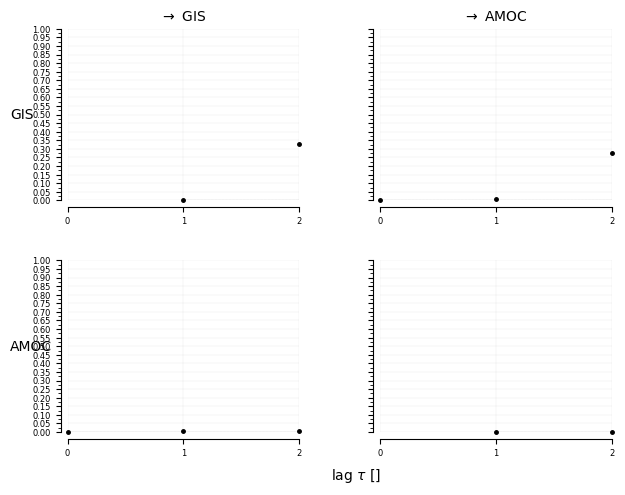

In [229]:
# Paramètres de base
lag_range = range(0, 11)  # tau_max de 0 à 10
var_names = ['GIS', 'AMOC']  # à adapter
N = len(var_names)
alpha = 0.05  # niveau de signification pour le test d'hypothèse

# Préparation de la figure
ncols = 4
nrows = int(np.ceil(len(lag_range) / ncols))
tau_max = 2
#for idx, tau_max in enumerate(lag_range):
result = pcmci.get_lagged_dependencies(
    tau_min=0,
    tau_max=tau_max,
    #val_only=True,
    alpha_level=alpha,
    fdr_method='fdr_bh'
)
val_matrix = result['val_matrix']
p_matrix = result['p_matrix']
#graph = result['graph']

tp.plot_lagfuncs(val_matrix=p_matrix, setup_args={
        'var_names': var_names, 'maximum':1, 'minimum':0, 'y_base':0.05, 'plot_gridlines': True,})

#     plot_graph(
#         graph=graph,
#         var_names=var_names,
#         node_size=0.2,
#         arrow_linewidth=5,
#         figsize=(6, 3),  # still required even if ax is implicitly used
#     )
#     #ax.set_title(f"tau_max = {tau_max}", fontsize=12)

# plt.tight_layout()
plt.show()


In [140]:
# lag_range = range(0, 11)  # tau_max from 0 to 5
# val_matrices = []
# mean_scores = []

# for tau_max in lag_range:
#     # Run lagged dependency test
#     result = pcmci.get_lagged_dependencies(
#         tau_min=0,
#         tau_max=tau_max,
#         val_only=False,
#         alpha_level=0.05,
#         fdr_method='fdr_bh'
#     )
#     graph = result['graph']
#     val_matrix = result['val_matrix']
#     p_matrix = result['p_matrix']
    
#     # Store the full val_matrix for further inspection if needed
#     val_matrices.append(val_matrix)
#     # Compute a global score: mean absolute dependence over all variables and lags
#     mean_val = abs(val_matrix).mean()
#     mean_scores.append(round(mean_val, 3))

# # Create DataFrame with results
# df_lag_comparison = pd.DataFrame({
#     "tau_max": list(lag_range),
#     "score": mean_scores
# })

# # Sort by score ascending (lower is better fit)
# df_lag_comparison = df_lag_comparison.sort_values(by="score", ascending=False).reset_index(drop=True)
# print(df_lag_comparison)


In [ ]:
idx_GrIS = 0
idx_AMOC = 1

results = []

for tau_max in lag_range:
    result = pcmci.get_lagged_dependencies(
        tau_min=0,
        tau_max=tau_max,
        val_only=False,
        alpha_level=0.05,
        fdr_method='fdr_bh'
    )
    val_matrix = result['val_matrix']
    
    # Extract relevant slices (lags from 0 to tau_max)
    # val_matrix shape : (n_vars, n_vars, tau_max+1)
    
    # GrIS → GrIS
    vals_GrIS_GrIS = val_matrix[idx_GrIS, idx_GrIS, :tau_max+1]
    lag_max_GrIS_GrIS = np.abs(vals_GrIS_GrIS).argmax()
    val_max_GrIS_GrIS = vals_GrIS_GrIS[lag_max_GrIS_GrIS]
    
    # AMOC → AMOC
    vals_AMOC_AMOC = val_matrix[idx_AMOC, idx_AMOC, :tau_max+1]
    lag_max_AMOC_AMOC = np.abs(vals_AMOC_AMOC).argmax()
    val_max_AMOC_AMOC = vals_AMOC_AMOC[lag_max_AMOC_AMOC]
    
    # GrIS → AMOC
    vals_GrIS_AMOC = val_matrix[idx_AMOC, idx_GrIS, :tau_max+1]
    lag_max_GrIS_AMOC = np.abs(vals_GrIS_AMOC).argmax()
    val_max_GrIS_AMOC = vals_GrIS_AMOC[lag_max_GrIS_AMOC]
    
    results.append({
        "tau_max": tau_max,
        "lag_max_GrIS_GrIS": lag_max_GrIS_GrIS,
        "val_max_GrIS_GrIS": val_max_GrIS_GrIS,
        "lag_max_AMOC_AMOC": lag_max_AMOC_AMOC,
        "val_max_AMOC_AMOC": val_max_AMOC_AMOC,
        "lag_max_GrIS_AMOC": lag_max_GrIS_AMOC,
        "val_max_GrIS_AMOC": val_max_GrIS_AMOC
    })

df_results = pd.DataFrame(results)
#print(df_results)

    tau_max  lag_max_GrIS_GrIS  val_max_GrIS_GrIS  lag_max_AMOC_AMOC  \
0         0                  0           0.000000                  0   
1         1                  1           0.110684                  1   
2         2                  1           0.119176                  1   
3         3                  1           0.137433                  1   
4         4                  1           0.144704                  1   
5         5                  1           0.142497                  1   
6         6                  1           0.129533                  1   
7         7                  1           0.146359                  1   
8         8                  1           0.145232                  1   
9         9                  1           0.146796                  1   
10       10                  1           0.149805                  1   

    val_max_AMOC_AMOC  lag_max_GrIS_AMOC  val_max_GrIS_AMOC  
0            0.000000                  0           0.162267  
1          

# SNN1 and total FWF

In [210]:
salinity = np.array(-SNN1_monthly_1958_2016)
fwf = np.array(freshwater_monthly)
years = np.array(years_1958_2016)
months = np.array(months_1958_2016)

In [211]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("SNN1", "Total FWF in the NA"))
fig.add_trace(go.Scatter(x=months, y=salinity, name="SNN1", line=dict(color='#00AAD4')), row=1, col=1)
fig.add_trace(go.Scatter(x=months, y=fwf, name="Total FWF in the NA", line=dict(color='#2AD4ff')), row=1, col=2)
fig.update_layout(height=400, width=1200, showlegend=False, plot_bgcolor='rgba(215, 238, 244, 0.3)')

In [212]:
data_fwf_salinity = np.hstack([fwf.reshape(-1, 1), salinity.reshape(-1, 1)])

In [213]:
n_points = 150

In [214]:
intervention_data, intervention_data_here = ind.produce_intervention_data(salinity, 0.01, 100)
dataframe = pp.DataFrame(data_fwf_salinity, var_names = ['fwf', 'salinity'])

list_causal_LinReg_fwf_on_salinity_intervention_data = []
for i in range(len(graphsCE)):
    graph = graphsCE[i]
    X = [(0,-i)] # FWF
    Y = [(1,0)] # Salinity

    causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)
    
    causal_effects.fit_total_effect(dataframe=dataframe, estimator=LinearRegression(), adjustment_set='optimal', conditional_estimator=None, data_transform=StandardScaler(), mask_type=None,)
    estimated_causal_effects_LinReg = causal_effects.predict_total_effect(intervention_data=intervention_data_here, transform_interventions_and_prediction=True,)
    #slopeKNN, interceptKNN = np.polyfit(intervention_data, estimated_causal_effects_KNN, 1)

    list_causal_LinReg_fwf_on_salinity_intervention_data.append(estimated_causal_effects_LinReg)

In [227]:
slopes = []
for sublist in list_causal_LinReg_fwf_on_salinity_intervention_data:
    x, y = np.arange(len(sublist)), np.array(sublist)
    slope, intercept = np.polyfit(x, y, 1)
    slopes.append(slope)

In [ ]:
x_labels = [f"Graph {i}" for i in range(len(slopes))]

fig = go.Figure()

for i, slope in enumerate(slopes):
    fig.add_trace(go.Scatter(
        x=[x_labels[i]],  # un seul label par point
        y=[slope],
        mode='markers+text',
        text=[f"{slope:.3f}"],  # affiche la valeur de la pente au-dessus
        textposition="top center",
        marker=dict(size=12, color=f'rgb({i*40}, {100 + i*30}, {200 - i*20})'),
    ))

fig.update_layout(
    xaxis=dict(title='Graphs', tickmode='array', tickvals=x_labels, ticktext=x_labels),
    yaxis=dict(title='Slope', showticklabels=False, range=[min(slopes)*(1.2), max(slopes)*(1.3)]),
    width=700, height=400, template='plotly_white', showlegend=False)

fig.show()

In [224]:
list_causal_LinReg_fwf_on_salinity_time = []
for i in range(len(graphsCE)):
    graph = graphsCE[i]
    X = [(0,-i)] # fwf
    Y = [(1,0)] # salinity

    causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)
    causal_effect_fwf_salinity, _, _ = ind.pipeline_causalEE_weighted(
    causal_effects, data_fwf_salinity, LinearRegression(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$fwf$', r'$salinity$'], edge_points_proportion=0.15)

    list_causal_LinReg_fwf_on_salinity_time.append(causal_effect_fwf_salinity)

In [225]:
start_index = window_length // 2
end_index = len(years_1871_2013) - (window_length // 2)
x = years_1871_2013[start_index:end_index]

fig = go.Figure()

for i, causal_LinReg_fwf_on_salinity in enumerate(list_causal_LinReg_fwf_on_salinity_time):
    fig.add_trace(go.Scatter(
        x=x, y=causal_LinReg_fwf_on_salinity, mode='lines',
        name=f'Lag {i}',
        line=dict(color=f'rgb({i*40}, {100 + i*30}, {200 - i*20})')
    ))

fig.update_layout(
    title='Evolution of the Causal Effect of fwf on Salinity at different lags',
    xaxis=dict(title='Year'), yaxis=dict(title='Causal Effect'),
    width=800, height=600, template='plotly_white'
)
fig.show()

## Seasonality processing

In [226]:
fwf = pd.Series(fwf, index = months)
salinity = pd.Series(salinity, index = months)

In [154]:
# Calcul de la climatologie mensuelle
fwf_clim = fwf.groupby(fwf.index.month).transform("mean")
salinity_clim = salinity.groupby(salinity.index.month).transform("mean")

# Anomalies (données désaisonnalisées)
fwf_anom = fwf - fwf_clim
salinity_anom = salinity - salinity_clim

In [157]:
# --- Climatologie mensuelle (1 à 12) ---
fwf_clim_monthly = fwf.groupby(fwf.index.month).mean()
salinity_clim_monthly = salinity.groupby(salinity.index.month).mean()

fig_clim = go.Figure()

fig_clim.add_trace(go.Scatter(x=fwf_clim_monthly.index, y=fwf_clim_monthly.values, mode="lines+markers", name="FWF climatology", yaxis="y1", line=dict(color='#00AAD4')))
fig_clim.add_trace(go.Scatter(x=salinity_clim_monthly.index, y=salinity_clim_monthly.values, mode="lines+markers", name="Salinity climatology", yaxis="y2", line=dict(color='#2AD4ff')))

fig_clim.update_layout(
    title="Seasonal cycle",
    xaxis=dict(title="Month", tickmode="array", tickvals=list(range(1,13))),
    yaxis=dict(title="FWF", side="left"),
    yaxis2=dict(title="Salinity", overlaying="y", side="right"),
    height=400, width=800, plot_bgcolor='rgba(215, 238, 244, 0.3)',
    legend=dict(x=0.05, y=0.9)
)

fig_clim.show()

In [161]:
# --- Anomalies (toute la série temporelle) ---
fig_anom = go.Figure()

fig_anom.add_trace(go.Scatter(x=fwf_anom.index, y=fwf_anom.values,mode="lines", name="FWF anomalies", yaxis="y1", line=dict(color='#00AAD4')))
fig_anom.add_trace(go.Scatter(x=salinity_anom.index, y=salinity_anom.values,mode="lines", name="Salinity anomalies", yaxis="y2", line=dict(color='#2AD4ff')))

fig_anom.update_layout(
    title="Deseasonalized anomalies",
    xaxis=dict(title="Time"),
    yaxis=dict(title="FWF anomalies", side="left"),
    yaxis2=dict(title="Salinity anomalies", overlaying="y", side="right"),
    height=400, width=800, plot_bgcolor='rgba(215, 238, 244, 0.3)',
    legend=dict(x=0.02, y=0.95)
)

fig_anom.show()

In [162]:
fwf = fwf_anom.values
salinity = salinity_anom.values

In [163]:
lags = range(-10, 11)

cross_correlations = []
for lag in lags:
    if lag < 0:
        corr = np.corrcoef(fwf[-lag:], salinity[:lag])[0, 1] if -lag < len(fwf) else None
    elif lag > 0:
        corr = np.corrcoef(fwf[:-lag], salinity[lag:])[0, 1] if lag < len(fwf) else None
    else:  # lag == 0
        corr = np.corrcoef(fwf, salinity)[0, 1]
    cross_correlations.append(corr)

df = pd.DataFrame({"Lag": lags,"Cross-Correlation": cross_correlations})
fig = px.scatter(
    df, x="Lag", y="Cross-Correlation", 
    title="Cross-Correlations between salinity and fwf",
    labels={"Lag": "Lag", "Cross-Correlation": "Cross-Correlation"},
    template="plotly_white"
)

fig.update_traces(marker=dict(size=10, color='purple'))
fig.update_layout(width=800,height=400)

fig.show()

In [164]:
data_fwf_salinity = np.hstack([fwf.reshape(-1, 1), salinity.reshape(-1, 1)])

In [172]:
n_points = 150

In [182]:
intervention_data, intervention_data_here = ind.produce_intervention_data(salinity, 0.01, 100)
dataframe = pp.DataFrame(data_fwf_salinity, var_names = ['fwf', 'salinity'])

list_causal_LinReg_fwf_on_salinity_intervention_data = []
for i in range(len(graphsCE)):
    graph = graphsCE[i]
    X = [(0,-i)] # FWF
    Y = [(1,0)] # Salinity

    causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)
    
    causal_effects.fit_total_effect(dataframe=dataframe, estimator=LinearRegression(), adjustment_set='optimal', conditional_estimator=None, data_transform=StandardScaler(), mask_type=None,)
    estimated_causal_effects_LinReg = causal_effects.predict_total_effect(intervention_data=intervention_data_here, transform_interventions_and_prediction=True,)
    #slopeKNN, interceptKNN = np.polyfit(intervention_data, estimated_causal_effects_KNN, 1)

    list_causal_LinReg_fwf_on_salinity_intervention_data.append(estimated_causal_effects_LinReg)

In [ ]:
slopes = []
for sublist in list_causal_LinReg_fwf_on_salinity_intervention_data:
    x, y = np.arange(len(sublist)), np.array(sublist)
    slope, intercept = np.polyfit(x, y, 1)
    slopes.append(slope)

In [ ]:
x_labels = [f"Graph {i}" for i in range(len(slopes))]

fig = go.Figure()

for i, slope in enumerate(slopes):
    fig.add_trace(go.Scatter(
        x=[x_labels[i]],  # un seul label par point
        y=[slope],
        mode='markers+text',
        text=[f"{slope:.3f}"],  # affiche la valeur de la pente au-dessus
        textposition="top center",
        marker=dict(size=12, color=f'rgb({i*40}, {100 + i*30}, {200 - i*20})'),
    ))

fig.update_layout(
    xaxis=dict(title='Graphs', tickmode='array', tickvals=x_labels, ticktext=x_labels),
    yaxis=dict(title='Slope', showticklabels=False, range=[min(slopes)*(1.1), max(slopes)*(0.7)]),
    width=700, height=400, template='plotly_white', showlegend=False)

fig.show()

In [ ]:
list_causal_LinReg_fwf_on_salinity_time = []
for i in range(len(graphsCE)):
    graph = graphsCE[i]
    X = [(0,-i)] # fwf
    Y = [(1,0)] # salinity

    causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)
    causal_effect_fwf_salinity, _, _ = ind.pipeline_causalEE_weighted(
    causal_effects, data_fwf_salinity, LinearRegression(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$fwf$', r'$salinity$'], edge_points_proportion=0.15)

    list_causal_LinReg_fwf_on_salinity_time.append(causal_effect_fwf_salinity)

In [ ]:
start_index = window_length // 2
end_index = len(years_1871_2013) - (window_length // 2)
x = years_1871_2013[start_index:end_index]

fig = go.Figure()

for i, causal_LinReg_fwf_on_salinity in enumerate(list_causal_LinReg_fwf_on_salinity_time):
    fig.add_trace(go.Scatter(
        x=x, y=causal_LinReg_fwf_on_salinity, mode='lines',
        name=f'Lag {i}',
        line=dict(color=f'rgb({i*40}, {100 + i*30}, {200 - i*20})')
    ))

fig.update_layout(
    title='Evolution of the Causal Effect of fwf on Salinity at different lags',
    xaxis=dict(title='Year'), yaxis=dict(title='Causal Effect'),
    width=800, height=600, template='plotly_white'
)
fig.show()

In [229]:
def rolling_deseasonalize(ts, window_length=70):
    """
    ts : pd.Series avec index datetime
    window : taille de la fenêtre glissante en mois pour calculer la climatologie locale
    
    Renvoie : pd.Series des anomalies désaisonnalisées
    """
    anomalies = pd.Series(index=ts.index, dtype=float)
    
    for start in range(len(ts) - window_length + 1):
        window_slice = ts.iloc[start:start+window_length]
        # Climatologie locale : moyenne par mois dans la fenêtre
        clim_window = window_slice.groupby(window_slice.index.month).transform("mean")
        anomalies.iloc[start:start+window_length] = window_slice - clim_window
    
    # Pour les premiers et derniers points (moins d'une fenêtre), on peut laisser NaN ou extrapoler
    anomalies[:window_length-1] = anomalies[window_length-1]
    anomalies[-(window_length-1):] = anomalies[-window_length]
    
    return anomalies


### rolling deseasonality

In [241]:
window_length = 72 # 6 years
fwf_anom_rolling = rolling_deseasonalize(fwf, window_length)
salinity_anom_rolling = rolling_deseasonalize(salinity, window_length)


/var/folders/lm/c2t_62cj4rg3ry50_0z2s5j00000gn/T/ipykernel_991/1961583831.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/lm/c2t_62cj4rg3ry50_0z2s5j00000gn/T/ipykernel_991/1961583831.py:18: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/lm/c2t_62cj4rg3ry50_0z2s5j00000gn/T/ipykernel_991/1961583831.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/lm/c2t_62cj4rg3ry50_0z2s5j00000gn/T/ipyker

In [242]:
fig_anom_rolling = go.Figure()

fig_anom_rolling.add_trace(
    go.Scatter(x=fwf_anom_rolling.index, y=fwf_anom_rolling.values,
               mode="lines", name="FWF rolling anomalies", yaxis="y1", line=dict(color='#00AAD4'))
)

fig_anom_rolling.add_trace(
    go.Scatter(x=salinity_anom_rolling.index, y=salinity_anom_rolling.values,
               mode="lines", name="Salinity rolling anomalies", yaxis="y2", line=dict(color='#2AD4ff'))
)

fig_anom_rolling.update_layout(
    title=f"Deseasonalized anomalies (rolling window = {window_length} months)",
    xaxis=dict(title="Time"),
    yaxis=dict(title="FWF anomalies", side="left"),
    yaxis2=dict(title="Salinity anomalies", overlaying="y", side="right"),
    height=400, width=900, plot_bgcolor='rgba(215, 238, 244, 0.3)',
    legend=dict(x=0.02, y=0.95)
)

fig_anom_rolling.show()


In [246]:
data_fwf_salinity = np.hstack([fwf_anom_rolling.values[window_length//2:-window_length//2].reshape(-1, 1), salinity_anom_rolling.values[window_length//2:-window_length//2].reshape(-1, 1)])

In [247]:
list_causal_LinReg_fwf_on_salinity_time = []
for i in range(len(graphsCE)):
    graph = graphsCE[i]
    X = [(0,-i)] # fwf
    Y = [(1,0)] # salinity

    causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                            hidden_variables=None, verbosity=0)
    causal_effect_fwf_salinity, _, _ = ind.pipeline_causalEE_weighted(
    causal_effects, data_fwf_salinity, LinearRegression(), StandardScaler(), n_points=n_points, time_windows=time_windows, var_names=[r'$fwf$', r'$salinity$'], edge_points_proportion=0.15)

    list_causal_LinReg_fwf_on_salinity_time.append(causal_effect_fwf_salinity)

In [248]:
start_index = window_length // 2
end_index = len(years_1871_2013) - (window_length // 2)
x = years_1871_2013[start_index:end_index]

fig = go.Figure()

for i, causal_LinReg_fwf_on_salinity in enumerate(list_causal_LinReg_fwf_on_salinity_time):
    fig.add_trace(go.Scatter(
        x=x, y=causal_LinReg_fwf_on_salinity, mode='lines',
        name=f'Lag {i}',
        line=dict(color=f'rgb({i*40}, {100 + i*30}, {200 - i*20})')
    ))

fig.update_layout(
    title='Evolution of the Causal Effect of fwf on Salinity at different lags',
    xaxis=dict(title='Year'), yaxis=dict(title='Causal Effect'),
    width=800, height=600, template='plotly_white'
)
fig.show()